In [1]:
# This is a machine learning project for the titanic Kaggle competition. 
# https://www.kaggle.com/c/titanic 
# The goal is to predict whether a passenger survived using the competition data which are mostly socioeconomical. 
# The training set must be used to train the machine learning instance while the test set is used to obtain the final score.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display  # This allow to display dataframe even if they are not the last thing of their cell.

# Read data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine_df = train_df.append(test_df)

# Print features
print(list(combine_df))
# Show small sample of data
combine_df.head()

['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket']


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [2]:
# See missing data and data type
train_df.info()
print('_'*40)
test_df.info()

# There are 891 training cases and 418 test cases. Age and cabin have a large number of NaNs. 
# Embarked has 2 NaN in the training data and fare has 1 in the testing data.
# All those NaN represents unknown values, XGBoost (the most used machine learning tools in Kaggle competition) can handdle them
# by itself, but other machine learning classifier needs that those values be replaced or removed.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [3]:
# information about the distribution of rhw numerical data
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
# information about categorical data
train_df.describe(include=['O'])
# Ticket and cabin have a very large number of unique cases. They can't be used at is. Embarked has 3 cases, thus can be used
# as dummy variables, while Sex can be one dummy variable.

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Mangan, Miss. Mary",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [8]:
# Study ticket feature
tmp = train_df.set_index('Ticket').sort_index()
print(tmp['Fare'])

# Ticket numbers and their fare are repeated. The best explanation is that when someone buy places for a group of people, there
# is only one ticket, which has only one fare which is for the group. Thus, a more representative informartion might be the fare
# per person. It is also possible that giving different ponderation for men, women and children would give a better predictor.

Ticket
110152               86.5000
110152               86.5000
110152               86.5000
110413               79.6500
110413               79.6500
110413               79.6500
110465               52.0000
110465               52.0000
110564               26.5500
110813               75.2500
111240               33.5000
111320               38.5000
111361               57.9792
111361               57.9792
111369               30.0000
111426               26.5500
111427               26.5500
111428               26.5500
112050                0.0000
112052                0.0000
112053               30.0000
112058                0.0000
112059                0.0000
112277               31.0000
112379               39.6000
113028               26.5500
113043               28.5000
113050               26.5500
113051               27.7500
113055               26.5500
                      ...   
STON/O 2. 3101274     7.1250
STON/O 2. 3101275     7.1250
STON/O 2. 3101280     7.9250
STON/O 

In [9]:
# Count number of people with same tickets.
combine_df = combine_df.join(combine_df.groupby(by='Ticket').size().rename('Ticket_count'),on='Ticket')
# Fare most likely means fare of the ticket rather than fare per person. 
# So I need to create this feature as it might be more useful than fare
combine_df['FarePerPerson']=combine_df['Fare']/combine_df['Ticket_count']
# The sum of Sibling, spouse, parent and children might be more useful than having Sibling and spouse, then parent and children
combine_df['Family'] = combine_df['SibSp'] + combine_df['Parch']
# One feature is enough for sex, no need to break into two when doing dummies.
combine_df['Sex'] = combine_df['Sex'].map( {'female': 1, 'male': 0} )
# PClass is not a real number, let's transform it into dummies.
combine_df['Pclass'] = combine_df['Pclass'].replace({1 : '1st',2 : '2nd',3 : '3rd'})

# Create title row. I will transform it with get dummies after that
# Titles in names are certainly useful, but there are too many instances. So it is useful to combine the rare titles together.
# Also titles related to unmarried women (Miss., Mlle.) should be together, idem for those of married women (Mrs. Mme.). 
# Ms. which is for unknown marital status may go either way.
def fun0(x):
    tmp = (x.split(',')[1]).split()[0]
    if tmp in ['Mr.','Master.','Dr.','Rev.']:
        return tmp
    elif tmp in ['Miss.', 'Mlle.', 'Ms.']:
        return 'Miss.'
    elif tmp in ['Mrs.', 'Mme.']:
        return 'Mrs.'
    else:
        return 'Other'
combine_df['title'] = combine_df['Name'].apply(fun0)

In [10]:
# Create same ticket survival
# People are more likely to die if the people who shared their ticket died.
# Especially if there are men and some women or children who shared their ticket died. It's not so true in the opposite direction
# since so many men died.
tmp1 = (combine_df.groupby(by='Ticket').count())['Survived']
tmp2 = (combine_df.groupby(by='Ticket').sum())['Survived']
combine_df['tmp1'] = combine_df['Ticket'].replace(to_replace=tmp1)   # Number of non_nan survived with same ticket
combine_df['tmp2'] = combine_df['Ticket'].replace(to_replace=tmp2)   # Sum of non_nan survived with same ticket

def f(row):
    if np.isnan(row['Survived']): # test
        if row['tmp1'] == 0 :
            val = np.nan
        else:
            val = row['tmp2'] /row['tmp1']
    else: # train
        if row['tmp1'] == 1 :
            val = np.nan
        else:
            val = (row['tmp2']-row['Survived']) / (row['tmp1']-1)
    return val
combine_df['SameTicketSurvival'] = combine_df.apply(f, axis=1)
combine_df = combine_df.drop('tmp1',axis=1).drop('tmp2',axis=1)

# Create same last name survival
# The same is true with last name, as they are likely to be in the same family.
combine_df['LastName'] = combine_df['Name'].apply(lambda x : (x.split(',')[0]))
tmp1 = (combine_df.groupby(by='LastName').count())['Survived']
tmp2 = (combine_df.groupby(by='LastName').sum())['Survived']
combine_df['tmp1'] = combine_df['LastName'].replace(to_replace=tmp1)   # Number of non_nan survived with same ticket
combine_df['tmp2'] = combine_df['LastName'].replace(to_replace=tmp2)   # Sum of non_nan survived with same ticket
combine_df['LastNameSurvival'] = combine_df.apply(f, axis=1)

display((combine_df.head())

# Remove LastName because there are two many different LastName, so it wouldn't work with get_dummies which is needed for xgboost.
# Same for ticket
# Same for Cabin, which has also too many missing values.
# PassengerID should not add any information as it is arbitrary
# Name is useless as everybody as a unique name.
combine_df = (combine_df.drop('tmp1',axis=1).drop('tmp2',axis=1).drop('LastName',axis=1).drop('Ticket',axis=1).
              drop('PassengerId',axis=1).drop('Cabin',axis=1).drop('Name',axis=1))
        
display((combine_df.head())

print(list(combine_df))

    Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

  Pclass  Sex  SibSp        ...                   Ticket Ticket_count  \
0    3rd    0      1        ...                A/5 21171            1   
1    1st    1      1        ...                 PC 17599            2   
2    3rd    1      0        ...         STON/O2. 3101282            1   
3    1st    1      1        ...         

In [74]:
# Create dummies for every string variable
combine_df = pd.get_dummies(combine_df)

# Split Other between gender
# That might be useful and the other title are mostly separated by gender.
print(list(combine_df))
combine_df['OtherFemale'] = combine_df['title_Other'] * combine_df['Sex'] + combine_df['title_Dr.'] * combine_df['Sex']
combine_df['OtherMale'] = combine_df['title_Other'] - combine_df['OtherFemale']

# Split classes between gender
# That might be useful since gender is a very important characteristic which interacts with the class since the boosted tree
# technic won't allow to always use the Sex characteristic to do a branching.
combine_df['1F'] = combine_df['Pclass_1st'] * combine_df['Sex']
combine_df['2F'] = combine_df['Pclass_2nd'] * combine_df['Sex']
combine_df['3F'] = combine_df['Pclass_3rd'] * combine_df['Sex']
combine_df['1M'] = combine_df['Pclass_1st'] - combine_df['1F']
combine_df['2M'] = combine_df['Pclass_2nd'] - combine_df['2F']
combine_df['3M'] = combine_df['Pclass_3rd'] - combine_df['3F']

['Age', 'Fare', 'Parch', 'Sex', 'SibSp', 'Survived', 'Ticket_count', 'FarePerPerson', 'Family', 'SameTicketSurvival', 'LastNameSurvival', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1st', 'Pclass_2nd', 'Pclass_3rd', 'title_Dr.', 'title_Master.', 'title_Miss.', 'title_Mr.', 'title_Mrs.', 'title_Other', 'title_Rev.']


In [75]:
# Separate in train and test
train_df = combine_df[pd.notnull(combine_df['Survived'])]
test_df = combine_df[False == pd.notnull(combine_df['Survived'])]

x = train_df.drop('Survived',axis=1)
y = train_df['Survived']

In [11]:
# XGBoost is known to be the best machine learning algorithm for this kind of task.
# Hyperopt is a good hyperparameter optimizer.

# XGBoost.cv selects the best number of estimators and gives a good cross validation scores.
# The 1st step is to find the best parameters using hyperopt and XGBoost.cv. Then, one uses those parameters to train a 
# classifier with all the data. However, an important difference between the use of XGBoost.cv and the final fitting is that
# with XGBoost.cv we split the data in 4/5 training set and 1/5 cross-validation set. Thus, the parameters may not be the best
# for the final training. It is particularly the case of n_estimators which has a use uncertainty.

import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from time import time
from random import randint

nrepeat = 20
repeat = range(nrepeat)

from sklearn.model_selection import KFold

dmatrix = xgb.DMatrix(x.values, y.values)

def objective(space):
    dmatrix = xgb.DMatrix(x.values, y.values)
    param={'learning_rate' : space['learning_rate'],
     'max_depth' : int(space['max_depth']),
     'min_child_weight' : space['min_child_weight'],
        'gamma' : space['gamma'],
     'subsample' : space['subsample'],
     'colsample_bytree' :space['colsample_bytree'],
     'nthread' : -1,
     'colsample_bylevel' :space['colsample_bylevel'],
        'reg_alpha' :space['reg_alpha'],
     'reg_lambda' :space['reg_lambda']  
          }
    error = 0
    for i in repeat:
        seed = randint(0, 100000)
        cvresult = xgb.cv(param, dmatrix, num_boost_round=1000, nfold=5,
                metrics='error', early_stopping_rounds=10, shuffle = True, seed=seed)
        error += cvresult['test-error-mean'].tail(1).values[0]
    error /= nrepeat

    return{'loss':error, 'status': STATUS_OK }


space ={
        'max_depth': hp.quniform ('max_depth', 1, 14, 1),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.1, 1.),
        'learning_rate' : hp.uniform ('learning_rate', 0.01, 0.5),
       'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1.),
        'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.5, 1.),
        'gamma': hp.uniform ('gamma', 0., 1.),
    'reg_alpha': hp.uniform ('reg_alpha', 0., 1.),
    'reg_lambda' : hp.uniform ('reg_lambda', 0., 1.)
    }

trials = Trials()
start_time = time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print("--- %s seconds ---" % (time() - start_time))

best['max_depth'] = int(best['max_depth'])
print (best)

import numpy as np
start_time = time()
n_estimators = []
Error = []
for i in range(100):
    seed = randint(0, 100000)
    cvresult = xgb.cv(best, dmatrix, num_boost_round=1000, nfold=5,
                metrics='error', early_stopping_rounds=50, shuffle = True, seed=seed)
    n_estimators.append(cvresult.shape[0])
    Error.append(cvresult['test-error-mean'].tail(1).values[0])
print("--- %s seconds ---" % (time() - start_time))
n_estimators_mean = np.mean(n_estimators)
n_estimators_std = np.std(n_estimators)
Error_mean = np.mean(Error)
Error_std = np.std(Error)
print(n_estimators_mean, n_estimators_std, Error_mean, Error_std)

best1 = best
best1['n_estimators'] = int(round(n_estimators_mean))
clf = xgb.XGBClassifier(**best1)
prediction1 = clf.fit(x,y).predict(test_df.drop('Survived',axis=1))

result_df = pd.read_csv('test.csv').drop('Pclass',axis=1).drop('Name',axis=1).drop('Sex',axis=1).drop('Age',axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('Ticket',axis=1).drop('Fare',axis=1).drop('Cabin',axis=1).drop('Embarked',axis=1)
result_df['Survived'] = pd.Series(data=prediction1)
result_df = result_df.set_index('PassengerId').astype(int)
print(result_df)

result_df.to_csv(path_or_buf='Result_Titanic')

--- 522.3922550678253 seconds ---
{'colsample_bylevel': 0.666283305643945, 'colsample_bytree': 0.96025711198482, 'gamma': 0.4538320367589998, 'learning_rate': 0.1672241327029708, 'max_depth': 10, 'min_child_weight': 1.0, 'reg_alpha': 0.22779378353622617, 'reg_lambda': 0.6926529168023405, 'subsample': 0.9995550469608545}
--- 102.16380286216736 seconds ---
11.4 12.7121988657 0.148246962 0.00511404120458
             Survived
PassengerId          
892                 0
893                 0
894                 0
895                 0
896                 1
897                 0
898                 1
899                 0
900                 1
901                 0
902                 0
903                 0
904                 1
905                 0
906                 1
907                 1
908                 0
909                 0
910                 0
911                 0
912                 0
913                 0
914                 1
915                 0
916                 1
9

In [19]:
# Try again with logloss rather than accuracy
evalmetrics = 'logloss'
nrepeat = 20
repeat = range(nrepeat)

from sklearn.model_selection import KFold

dmatrix = xgb.DMatrix(x.values, y.values)

def objective(space):
    dmatrix = xgb.DMatrix(x.values, y.values)
    param={'learning_rate' : space['learning_rate'],
     'max_depth' : int(space['max_depth']),
     'min_child_weight' : space['min_child_weight'],
        'gamma' : space['gamma'],
     'subsample' : space['subsample'],
     'colsample_bytree' :space['colsample_bytree'],
     'nthread' : -1,
     'colsample_bylevel' :space['colsample_bylevel'],
        'reg_alpha' :space['reg_alpha'],
     'reg_lambda' :space['reg_lambda']  
          }
    error = 0
    for i in repeat:
        seed = randint(0, 100000)
        cvresult = xgb.cv(param, dmatrix, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=10, shuffle = True, seed=seed)
        error += cvresult['test-logloss-mean'].tail(1).values[0]
    error /= nrepeat

    return{'loss':1-error, 'status': STATUS_OK }


space ={
        'max_depth': hp.quniform ('max_depth', 1, 14, 1),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.1, 1.),
        'learning_rate' : hp.uniform ('learning_rate', 0.01, 0.5),
       'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1.),
        'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.5, 1.),
        'gamma': hp.uniform ('gamma', 0., 1.),
    'reg_alpha': hp.uniform ('reg_alpha', 0., 1.),
    'reg_lambda' : hp.uniform ('reg_lambda', 0., 1.)
    }

trials = Trials()
start_time = time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print("--- %s seconds ---" % (time() - start_time))

best['max_depth'] = int(best['max_depth'])
print (best)

import numpy as np
start_time = time()
n_estimators = []
Error = []
for i in range(100):
    seed = randint(0, 100000)
    cvresult = xgb.cv(best, dmatrix, num_boost_round=1000, nfold=5,
                metrics='logloss', early_stopping_rounds=50, shuffle = True, seed=seed)
    n_estimators.append(cvresult.shape[0])
    Error.append(cvresult['test-logloss-mean'].tail(1).values[0])
print("--- %s seconds ---" % (time() - start_time))
n_estimators_mean = np.mean(n_estimators)
n_estimators_std = np.std(n_estimators)
Error_mean = np.mean(Error)
Error_std = np.std(Error)
print(n_estimators_mean, n_estimators_std, Error_mean, Error_std)

best2 = best
best2['n_estimators'] = int(round(n_estimators_mean))
clf = xgb.XGBClassifier(**best2)
prediction2 = clf.fit(x,y).predict(test_df.drop('Survived',axis=1))

result_df = pd.read_csv('test.csv').drop('Pclass',axis=1).drop('Name',axis=1).drop('Sex',axis=1).drop('Age',axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('Ticket',axis=1).drop('Fare',axis=1).drop('Cabin',axis=1).drop('Embarked',axis=1)
result_df['Survived'] = pd.Series(data=prediction2)
result_df = result_df.set_index('PassengerId').astype(int)
print(result_df)

result_df.to_csv(path_or_buf='Result_Titanic2')

--- 541.779257774353 seconds ---
{'colsample_bylevel': 0.8793854140464347, 'colsample_bytree': 0.5284021992184958, 'gamma': 0.4877440792405143, 'learning_rate': 0.44616929141410355, 'max_depth': 4, 'min_child_weight': 5.0, 'reg_alpha': 0.40433603353443726, 'reg_lambda': 0.2570910174307357, 'subsample': 0.10055864508343322}
--- 35.055745363235474 seconds ---
3.59 0.939095309327 0.368803328667 0.156626686268
             Survived
PassengerId          
892                 0
893                 1
894                 0
895                 0
896                 1
897                 0
898                 1
899                 0
900                 1
901                 0
902                 0
903                 0
904                 1
905                 0
906                 1
907                 1
908                 0
909                 0
910                 1
911                 1
912                 0
913                 0
914                 1
915                 0
916               

In [21]:
# Try again with AUC
evalmetrics = 'auc'
nrepeat = 20
repeat = range(nrepeat)

from sklearn.model_selection import KFold

dmatrix = xgb.DMatrix(x.values, y.values)

def objective(space):
    dmatrix = xgb.DMatrix(x.values, y.values)
    param={'learning_rate' : space['learning_rate'],
     'max_depth' : int(space['max_depth']),
     'min_child_weight' : space['min_child_weight'],
        'gamma' : space['gamma'],
     'subsample' : space['subsample'],
     'colsample_bytree' :space['colsample_bytree'],
     'nthread' : -1,
     'colsample_bylevel' :space['colsample_bylevel'],
        'reg_alpha' :space['reg_alpha'],
     'reg_lambda' :space['reg_lambda']  
          }
    error = 0
    for i in repeat:
        seed = randint(0, 100000)
        cvresult = xgb.cv(param, dmatrix, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=10, shuffle = True, seed=seed)
        error += cvresult['test-auc-mean'].tail(1).values[0]
    error /= nrepeat

    return{'loss':1-error, 'status': STATUS_OK }


space ={
        'max_depth': hp.quniform ('max_depth', 1, 14, 1),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.1, 1.),
        'learning_rate' : hp.uniform ('learning_rate', 0.01, 0.5),
       'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1.),
        'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.5, 1.),
        'gamma': hp.uniform ('gamma', 0., 1.),
    'reg_alpha': hp.uniform ('reg_alpha', 0., 1.),
    'reg_lambda' : hp.uniform ('reg_lambda', 0., 1.)
    }

trials = Trials()
start_time = time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print("--- %s seconds ---" % (time() - start_time))

best['max_depth'] = int(best['max_depth'])
print (best)

import numpy as np
start_time = time()
n_estimators = []
Error = []
for i in range(100):
    seed = randint(0, 100000)
    cvresult = xgb.cv(best, dmatrix, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=50, shuffle = True, seed=seed)
    n_estimators.append(cvresult.shape[0])
    Error.append(cvresult['test-auc-mean'].tail(1).values[0])
print("--- %s seconds ---" % (time() - start_time))
n_estimators_mean = np.mean(n_estimators)
n_estimators_std = np.std(n_estimators)
Error_mean = np.mean(Error)
Error_std = np.std(Error)
print(n_estimators_mean, n_estimators_std, Error_mean, Error_std)

best3 = best
best3['n_estimators'] = int(round(n_estimators_mean))
clf = xgb.XGBClassifier(**best3)
prediction3 = clf.fit(x,y).predict(test_df.drop('Survived',axis=1))

result_df = pd.read_csv('test.csv').drop('Pclass',axis=1).drop('Name',axis=1).drop('Sex',axis=1).drop('Age',axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('Ticket',axis=1).drop('Fare',axis=1).drop('Cabin',axis=1).drop('Embarked',axis=1)
result_df['Survived'] = pd.Series(data=prediction3)
result_df = result_df.set_index('PassengerId').astype(int)
print(result_df)

result_df.to_csv(path_or_buf='Result_Titanic3')

--- 633.4523627758026 seconds ---
{'colsample_bylevel': 0.8227348764961984, 'colsample_bytree': 0.6545074153813044, 'gamma': 0.2883553402434034, 'learning_rate': 0.09387314161078095, 'max_depth': 5, 'min_child_weight': 2.0, 'reg_alpha': 0.17679068520207764, 'reg_lambda': 0.7885048250495174, 'subsample': 0.8616149029297578}
--- 76.12603735923767 seconds ---
30.14 38.6872123576 0.50046164 0.265336393349
             Survived
PassengerId          
892                 0
893                 1
894                 0
895                 0
896                 1
897                 0
898                 1
899                 0
900                 1
901                 0
902                 0
903                 0
904                 1
905                 0
906                 1
907                 1
908                 0
909                 0
910                 0
911                 1
912                 0
913                 0
914                 1
915                 0
916                 1
9

In [27]:
# Compare predictions

prediction1 = pd.read_csv('Result_Titanic')
prediction2 = pd.read_csv('Result_Titanic2')
prediction3 = pd.read_csv('Result_Titanic3')

# The output is the number of different result
print((prediction1 - prediction2).abs().sum()['Survived'])
print((prediction1 - prediction3).abs().sum()['Survived'])
print((prediction2 - prediction3).abs().sum()['Survived'])

# I got 0.79904 for 'Result_Titanic', that is 334/418
# I got 0.7751 for 'Result_Titanic2', that is 324/418    
    # Thus I got 10 less in 40 different, that means 15 good changes and 25 bad changes
# I got 0.80383, for 'Result_Titanic3', that is 336/418
    # Thus I got 2 more in 16 different, that means 9 good changes and 7 bad changes
    # Thus I got 12 more in 32 different, that means 22 good changes and 10 bad changes
    
# AUC is slightly better than accuracy, but it might just be luck. LogLoss is significantly less good.

40
16
32


In [49]:
# Try AUC with more nestimators     We have n_estimators_mean=30.14 n_estimators_std=38.6872123576 
# It might be better to be more precise and to go higher than the mean since the standard deviation is so large, thus we don't
# know if the mean is close to the good number for the final training. One might hope that more estimators is better than less
# and we have all the data for the final training while only 4/5 for the cv, so it is normal to believe that more estimators
# could be good.

evalmetrics = 'auc'
start_time = time()
best30 = best3
if 'n_estimators' in best30: del best30['n_estimators']
n_estimators = []
Error = []
for i in range(1000):
    seed = randint(0, 100000)
    cvresult = xgb.cv(best, dmatrix, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=50, shuffle = True, seed=seed)
    n_estimators.append(cvresult.shape[0])
    Error.append(cvresult['test-auc-mean'].tail(1).values[0])
print("--- %s seconds ---" % (time() - start_time))
n_estimators_mean = np.mean(n_estimators)
n_estimators_std = np.std(n_estimators)
Error_mean = np.mean(Error)
Error_std = np.std(Error)
print(n_estimators_mean, n_estimators_std, Error_mean, Error_std)
# Somehow, n_estimators_std do not decrease when range(1000) increases. That means it's not gaussian.

best30['n_estimators'] = int(round(n_estimators_mean))
clf = xgb.XGBClassifier(**best30)
prediction30 = clf.fit(x,y).predict(test_df.drop('Survived',axis=1))

result_df = pd.read_csv('test.csv').drop('Pclass',axis=1).drop('Name',axis=1).drop('Sex',axis=1).drop('Age',axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('Ticket',axis=1).drop('Fare',axis=1).drop('Cabin',axis=1).drop('Embarked',axis=1)
result_df['Survived'] = pd.Series(data=prediction30)
result_df = result_df.set_index('PassengerId').astype(int)
print(result_df)

result_df.to_csv(path_or_buf='Result_Titanic30')
# I got 0.80383


# Try with more n_estimators
best31 = best3
best31['n_estimators'] = int(round(n_estimators_mean + n_estimators_std))
clf = xgb.XGBClassifier(**best31)
prediction31 = clf.fit(x,y).predict(test_df.drop('Survived',axis=1))

result_df = pd.read_csv('test.csv').drop('Pclass',axis=1).drop('Name',axis=1).drop('Sex',axis=1).drop('Age',axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('Ticket',axis=1).drop('Fare',axis=1).drop('Cabin',axis=1).drop('Embarked',axis=1)
result_df['Survived'] = pd.Series(data=prediction31)
result_df = result_df.set_index('PassengerId').astype(int)
print(result_df)

result_df.to_csv(path_or_buf='Result_Titanic31')
# I got 0.78947

# It seems it's not the case.

--- 909.685076713562 seconds ---
38.553 43.7054595102 0.8954749328 0.0038582568371
             Survived
PassengerId          
892                 0
893                 0
894                 0
895                 0
896                 1
897                 0
898                 1
899                 0
900                 1
901                 0
902                 0
903                 0
904                 1
905                 0
906                 1
907                 1
908                 0
909                 0
910                 0
911                 1
912                 0
913                 0
914                 1
915                 0
916                 1
917                 0
918                 1
919                 0
920                 0
921                 0
...               ...
1280                0
1281                0
1282                0
1283                1
1284                1
1285                0
1286                0
1287                1
1288           

In [29]:
help(clf.fit)

Help on method fit in module xgboost.sklearn:

fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True) method of xgboost.sklearn.XGBClassifier instance
    Fit gradient boosting classifier
    
    Parameters
    ----------
    X : array_like
        Feature matrix
    y : array_like
        Labels
    sample_weight : array_like
        Weight for each instance
    eval_set : list, optional
        A list of (X, y) pairs to use as a validation set for
        early-stopping
    eval_metric : str, callable, optional
        If a str, should be a built-in evaluation metric to use. See
        doc/parameter.md. If callable, a custom evaluation metric. The call
        signature is func(y_predicted, y_true) where y_true will be a
        DMatrix object such that you may need to call the get_label
        method. It must return a str, value pair where the str is a name
        for the evaluation and value is the value of the evaluation
      

In [38]:
# Maybe always use early stopping
# It has however the bad effect to make that we can't use all the data.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
eval_set=[(X_test, y_test)]
bestES=best3 # Use the best set of parameter
bestES['n_estimators'] = 1000 # Need to be large so the stopping is by early stopping
clf = xgb.XGBClassifier(**bestES)
clf.fit(X_train,y_train, eval_set=eval_set,early_stopping_rounds=50, eval_metric='auc', verbose=False)
prediction4 = clf.predict(test_df.drop('Survived',axis=1))

result_df = pd.read_csv('test.csv').drop('Pclass',axis=1).drop('Name',axis=1).drop('Sex',axis=1).drop('Age',axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('Ticket',axis=1).drop('Fare',axis=1).drop('Cabin',axis=1).drop('Embarked',axis=1)
result_df['Survived'] = pd.Series(data=prediction4)
result_df = result_df.set_index('PassengerId').astype(int)

result_df.to_csv(path_or_buf='Result_Titanic4')

prediction4 = pd.read_csv('Result_Titanic4')
print((prediction4 - prediction3).abs().sum()['Survived'])

# I got 0.78469

12


In [10]:
# Try to separate first between male and female since they are very different samples.

import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from time import time
from random import randint
import numpy as np

trainM_df = train_df[train_df['Sex']==0]
trainF_df = train_df[train_df['Sex']==1]
testM_df = test_df[test_df['Sex']==0]
testF_df = test_df[test_df['Sex']==1]

xM = trainM_df.drop('Survived',axis=1)
yM = trainM_df['Survived']
xF= trainF_df.drop('Survived',axis=1)
yF = trainF_df['Survived']

dmatrixM = xgb.DMatrix(xM.values, yM.values)
dmatrixF = xgb.DMatrix(xF.values, yF.values)

evalmetrics = 'auc'
nrepeat = 20
repeat = range(nrepeat)
def objectiveM(space):
    param={'learning_rate' : space['learning_rate'],
     'max_depth' : int(space['max_depth']),
     'min_child_weight' : space['min_child_weight'],
        'gamma' : space['gamma'],
     'subsample' : space['subsample'],
     'colsample_bytree' :space['colsample_bytree'],
     'nthread' : -1,
     'colsample_bylevel' :space['colsample_bylevel'],
        'reg_alpha' :space['reg_alpha'],
     'reg_lambda' :space['reg_lambda']  
          }
    error = 0
    for i in repeat:
        seed = randint(0, 100000)
        cvresult = xgb.cv(param, dmatrixM, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=10, shuffle = True, seed=seed)
        error += cvresult['test-auc-mean'].tail(1).values[0]
    error /= nrepeat

    return{'loss':1-error, 'status': STATUS_OK }
def objectiveF(space):
    param={'learning_rate' : space['learning_rate'],
     'max_depth' : int(space['max_depth']),
     'min_child_weight' : space['min_child_weight'],
        'gamma' : space['gamma'],
     'subsample' : space['subsample'],
     'colsample_bytree' :space['colsample_bytree'],
     'nthread' : -1,
     'colsample_bylevel' :space['colsample_bylevel'],
        'reg_alpha' :space['reg_alpha'],
     'reg_lambda' :space['reg_lambda']  
          }
    error = 0
    for i in repeat:
        seed = randint(0, 100000)
        cvresult = xgb.cv(param, dmatrixF, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=10, shuffle = True, seed=seed)
        error += cvresult['test-auc-mean'].tail(1).values[0]
    error /= nrepeat

    return{'loss':1-error, 'status': STATUS_OK }

space ={
        'max_depth': hp.quniform ('max_depth', 1, 14, 1),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.1, 1.),
        'learning_rate' : hp.uniform ('learning_rate', 0.01, 0.5),
       'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1.),
        'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.5, 1.),
        'gamma': hp.uniform ('gamma', 0., 1.),
    'reg_alpha': hp.uniform ('reg_alpha', 0., 1.),
    'reg_lambda' : hp.uniform ('reg_lambda', 0., 1.)
    }

trials = Trials()
start_time = time()
bestM = fmin(fn=objectiveM,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
bestF = fmin(fn=objectiveF,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print("--- %s seconds ---" % (time() - start_time))

bestM['max_depth'] = int(bestM['max_depth'])
bestF['max_depth'] = int(bestF['max_depth'])
print (bestM)
print (bestF)

start_time = time()
n_estimators = []
for i in range(100):
    seed = randint(0, 100000)
    cvresult = xgb.cv(bestM, dmatrixM, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=50, shuffle = True, seed=seed)
    n_estimators.append(cvresult.shape[0])
n_estimators_meanM = np.mean(n_estimators)
    
for i in range(100):
    seed = randint(0, 100000)
    cvresult = xgb.cv(bestF, dmatrixF, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=50, shuffle = True, seed=seed)
    n_estimators.append(cvresult.shape[0])
n_estimators_meanF = np.mean(n_estimators)
    
print("--- %s seconds ---" % (time() - start_time))

bestM['n_estimators'] = int(round(n_estimators_meanM))
bestF['n_estimators'] = int(round(n_estimators_meanF))
clf = xgb.XGBClassifier(**bestM)
predictionM = clf.fit(xM,yM).predict(testM_df.drop('Survived',axis=1))
clf = xgb.XGBClassifier(**bestF)
predictionF = clf.fit(xF,yF).predict(testF_df.drop('Survived',axis=1))

result_df = pd.read_csv('test.csv').drop('Pclass',axis=1).drop('Name',axis=1).drop('Age',axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('Ticket',axis=1).drop('Fare',axis=1).drop('Cabin',axis=1).drop('Embarked',axis=1)
result_df['Survived'] = result_df['Sex']
result_df['Survived'].loc[result_df['Sex']=='male'] = predictionM
result_df['Survived'].loc[result_df['Sex']=='female'] = predictionF
result_df = result_df.set_index('PassengerId').drop('Sex',axis=1).astype(int)
print(result_df)

result_df.to_csv(path_or_buf='Result_Titanic6')

--- 412.9174773693085 seconds ---
{'colsample_bylevel': 0.9235200762181645, 'colsample_bytree': 0.822453160665294, 'gamma': 0.7791936249481772, 'learning_rate': 0.1955450438296506, 'max_depth': 6, 'min_child_weight': 1.0, 'reg_alpha': 0.7308280629929902, 'reg_lambda': 0.4987932979468526, 'subsample': 0.8200814329518703}
{'colsample_bylevel': 0.9235200762181645, 'colsample_bytree': 0.822453160665294, 'gamma': 0.7791936249481772, 'learning_rate': 0.1955450438296506, 'max_depth': 6, 'min_child_weight': 1.0, 'reg_alpha': 0.7308280629929902, 'reg_lambda': 0.4987932979468526, 'subsample': 0.8200814329518703}
--- 155.65548515319824 seconds ---


IndexingError: Unalignable boolean Series key provided

In [34]:
result_df = pd.read_csv('test.csv').drop('Pclass',axis=1).drop('Name',axis=1).drop('Age',axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('Ticket',axis=1).drop('Fare',axis=1).drop('Cabin',axis=1).drop('Embarked',axis=1)
result_df['Survived'] = result_df['Sex']
result_df['Survived'].loc[result_df['Sex']=='male'] = predictionM
result_df['Survived'].loc[result_df['Sex']=='female'] = predictionF
result_df = result_df.set_index('PassengerId').drop('Sex',axis=1).astype(int)
print(result_df)

result_df.to_csv(path_or_buf='Result_Titanic6')

# I got 0.79426
# So it wasn't a good idea.

             Survived
PassengerId          
892                 0
893                 0
894                 0
895                 0
896                 1
897                 0
898                 1
899                 0
900                 1
901                 0
902                 0
903                 0
904                 1
905                 0
906                 1
907                 1
908                 0
909                 0
910                 0
911                 0
912                 0
913                 0
914                 1
915                 0
916                 1
917                 0
918                 1
919                 0
920                 1
921                 0
...               ...
1280                0
1281                0
1282                0
1283                1
1284                1
1285                0
1286                0
1287                1
1288                0
1289                1
1290                0
1291                0
1292      

C:\Users\nicol\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [70]:
# Add Cabin features

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine_df = train_df.append(test_df)

combine_df = combine_df.join(combine_df.groupby(by='Ticket').size().rename('Ticket_count'),on='Ticket')
combine_df['FarePerPerson']=combine_df['Fare']/combine_df['Ticket_count']
combine_df['Family'] = combine_df['SibSp'] + combine_df['Parch']
combine_df['Sex'] = combine_df['Sex'].map( {'female': 1, 'male': 0} )
# PClass is not a real number, let's transform it into dummies.
combine_df['Pclass'] = combine_df['Pclass'].replace({1 : '1st',2 : '2nd',3 : '3rd'})

# Create title row.
def fun0(x):
    tmp = (x.split(',')[1]).split()[0]
    if tmp in ['Mr.','Master.','Dr.','Rev.']:
        return tmp
    elif tmp in ['Miss.', 'Mlle.', 'Ms.']:
        return 'Miss.'
    elif tmp in ['Mrs.', 'Mme.']:
        return 'Mrs.'
    else:
        return 'Other'
combine_df['title'] = combine_df['Name'].apply(fun0)

# Create same ticket survival
tmp1 = (combine_df.groupby(by='Ticket').count())['Survived']
tmp2 = (combine_df.groupby(by='Ticket').sum())['Survived']
combine_df['tmp1'] = combine_df['Ticket'].replace(to_replace=tmp1)   # Number of non_nan survived with same ticket
combine_df['tmp2'] = combine_df['Ticket'].replace(to_replace=tmp2)   # Sum of non_nan survived with same ticket

def f(row):
    if np.isnan(row['Survived']): # test
        if row['tmp1'] == 0 :
            val = np.nan
        else:
            val = row['tmp2'] /row['tmp1']
    else: # train
        if row['tmp1'] == 1 :
            val = np.nan
        else:
            val = (row['tmp2']-row['Survived']) / (row['tmp1']-1)
    return val
combine_df['SameTicketSurvival'] = combine_df.apply(f, axis=1)
combine_df = combine_df.drop('tmp1',axis=1).drop('tmp2',axis=1)

# Create same last name survival
combine_df['LastName'] = combine_df['Name'].apply(lambda x : (x.split(',')[0]))
tmp1 = (combine_df.groupby(by='LastName').count())['Survived']
tmp2 = (combine_df.groupby(by='LastName').sum())['Survived']
combine_df['tmp1'] = combine_df['LastName'].replace(to_replace=tmp1)   # Number of non_nan survived with same ticket
combine_df['tmp2'] = combine_df['LastName'].replace(to_replace=tmp2)   # Sum of non_nan survived with same ticket
combine_df['LastNameSurvival'] = combine_df.apply(f, axis=1)
combine_df = (combine_df.drop('tmp1',axis=1).drop('tmp2',axis=1).drop('PassengerId',axis=1).drop('Name',axis=1))

# Use only first cabin
combine_df['Cabin'] = combine_df['Cabin'].apply(lambda x: x.split()[0] if x == x else x)

# Fill cabin with last name
for s in combine_df.groupby(by='Ticket')['Cabin']:
    s1=s[1]  # s[0] is the Last Name
    s1.fillna(method='ffill', inplace=True)
    s1.fillna(method='bfill', inplace=True)
    
# Fill cabin with ticket
for s in combine_df.groupby(by='Ticket')['Cabin']:
    s1=s[1]  # s[0] is the ticket number
    s1.fillna(method='ffill', inplace=True)
    s1.fillna(method='bfill', inplace=True)
    
# Split cabin into letter and integer
combine_df['CabinLetter'] = combine_df['Cabin'].apply(lambda x: x[0] if x == x else x)
def tmp(x):
    if x != x :
        return x
    elif len(x)>1:
        return float(x[1:])
    else:
        return np.nan
combine_df['CabinNumber'] = combine_df['Cabin'].apply(tmp)

# Drop features with too many categories
combine_df = combine_df.drop('LastName',axis=1).drop('Ticket',axis=1).drop('Cabin',axis=1)
    
# Create dummies for every string variable
combine_df = pd.get_dummies(combine_df)

# Split Other between gender
combine_df['OtherFemale'] = combine_df['title_Other'] * combine_df['Sex'] + combine_df['title_Dr.'] * combine_df['Sex']
combine_df['OtherMale'] = combine_df['title_Other'] - combine_df['OtherFemale']

# Split classes between gender
combine_df['1F'] = combine_df['Pclass_1st'] * combine_df['Sex']
combine_df['2F'] = combine_df['Pclass_2nd'] * combine_df['Sex']
combine_df['3F'] = combine_df['Pclass_3rd'] * combine_df['Sex']
combine_df['1M'] = combine_df['Pclass_1st'] - combine_df['1F']
combine_df['2M'] = combine_df['Pclass_2nd'] - combine_df['2F']
combine_df['3M'] = combine_df['Pclass_3rd'] - combine_df['3F']

# Separate in train and test
train_df = combine_df[pd.notnull(combine_df['Survived'])]
test_df = combine_df[False == pd.notnull(combine_df['Survived'])]
x = train_df.drop('Survived',axis=1)
y = train_df['Survived']

nrepeat = 20
repeat = range(nrepeat)

from sklearn.model_selection import KFold

dmatrix = xgb.DMatrix(x.values, y.values)

def objective(space):
    param={'learning_rate' : space['learning_rate'],
     'max_depth' : int(space['max_depth']),
     'min_child_weight' : space['min_child_weight'],
        'gamma' : space['gamma'],
     'subsample' : space['subsample'],
     'colsample_bytree' :space['colsample_bytree'],
     'nthread' : -1,
     'colsample_bylevel' :space['colsample_bylevel'],
        'reg_alpha' :space['reg_alpha'],
     'reg_lambda' :space['reg_lambda']  
          }
    error = 0
    for i in repeat:
        seed = randint(0, 100000)
        cvresult = xgb.cv(param, dmatrix, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=10, shuffle = True, seed=seed)
        if evalmetrics == 'auc':
            error += 1-cvresult['test-auc-mean'].tail(1).values[0]
        elif evalmetrics == 'error':
            error += cvresult['test-error-mean'].tail(1).values[0]
    error /= nrepeat

    return error


space ={
        'max_depth': hp.quniform ('max_depth', 1, 14, 1),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.1, 1.),
        'learning_rate' : hp.uniform ('learning_rate', 0.01, 0.5),
       'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1.),
        'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.5, 1.),
        'gamma': hp.uniform ('gamma', 0., 1.),
    'reg_alpha': hp.uniform ('reg_alpha', 0., 1.),
    'reg_lambda' : hp.uniform ('reg_lambda', 0., 1.)
    }

start_time = time()
evalmetrics = 'auc'
bestAUC = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)
evalmetrics = 'error'
bestError = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)
print("--- %s seconds ---" % (time() - start_time))

bestAUC['max_depth'] = int(bestAUC['max_depth'])
print (bestAUC)
bestError['max_depth'] = int(bestError['max_depth'])
print (bestError)

import numpy as np
start_time = time()
n_estimatorsAUC = []
n_estimatorsError = []
for i in range(100):
    seed = randint(0, 100000)
    cvresult = xgb.cv(bestAUC, dmatrix, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=50, shuffle = True, seed=seed)
    n_estimatorsAUC.append(cvresult.shape[0])
for i in range(100):
    seed = randint(0, 100000)
    cvresult = xgb.cv(bestError, dmatrix, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=50, shuffle = True, seed=seed)
    n_estimatorsError.append(cvresult.shape[0])
print("--- %s seconds ---" % (time() - start_time))
n_estimatorsAUC_mean = np.mean(n_estimatorsAUC)
n_estimatorsError_mean = np.mean(n_estimatorsError)
print(n_estimatorsAUC_mean, n_estimatorsError_mean)

bestAUC['n_estimators'] = int(round(n_estimatorsAUC_mean))
clf = xgb.XGBClassifier(**bestAUC)
predictionAUC = clf.fit(x,y).predict(test_df.drop('Survived',axis=1))
result_df = pd.read_csv('test.csv').drop('Pclass',axis=1).drop('Name',axis=1).drop('Sex',axis=1).drop('Age',axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('Ticket',axis=1).drop('Fare',axis=1).drop('Cabin',axis=1).drop('Embarked',axis=1)
result_df['Survived'] = pd.Series(data=predictionAUC)
result_df = result_df.set_index('PassengerId').astype(int)
result_df.to_csv(path_or_buf='Result_TitanicAUC')

bestError['n_estimators'] = int(round(n_estimatorsError_mean))
clf = xgb.XGBClassifier(**bestError)
predictionError = clf.fit(x,y).predict(test_df.drop('Survived',axis=1))
result_df = pd.read_csv('test.csv').drop('Pclass',axis=1).drop('Name',axis=1).drop('Sex',axis=1).drop('Age',axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('Ticket',axis=1).drop('Fare',axis=1).drop('Cabin',axis=1).drop('Embarked',axis=1)
result_df['Survived'] = pd.Series(data=predictionError)
result_df = result_df.set_index('PassengerId').astype(int)
result_df.to_csv(path_or_buf='Result_TitanicError')

# Differences between AUC and Error
print((pd.Series(data=predictionAUC) - pd.Series(data=predictionError)).abs().sum())

# I got 0.77990 for AUC
# I got 0.79426 for Error

# Still less than initial answer.

--- 1369.4690580368042 seconds ---
{'colsample_bylevel': 0.822266637784425, 'colsample_bytree': 0.7688159874607244, 'gamma': 0.24141815239315229, 'learning_rate': 0.1519318808587794, 'max_depth': 5, 'min_child_weight': 8.0, 'reg_alpha': 0.8767988943536921, 'reg_lambda': 0.29774614494309326, 'subsample': 0.7056111963447809}
{'colsample_bylevel': 0.8762569525817361, 'colsample_bytree': 0.7754800031185707, 'gamma': 0.2571815526593193, 'learning_rate': 0.20786990229752467, 'max_depth': 6, 'min_child_weight': 5.0, 'reg_alpha': 0.5395288974302214, 'reg_lambda': 0.3170365728183162, 'subsample': 0.5669572593505213}
--- 9916.568351268768 seconds ---
35.21 32.69
17.0


In [82]:
# Stack classifier
# Rather than find the n_estimators_mean and then use it on all data. 
# I train 5 classifier with 20% data as CV to do early stopping. Then they vote.

bestES={'colsample_bylevel': 0.8227348764961984, 'colsample_bytree': 0.6545074153813044, 'gamma': 0.2883553402434034, 'learning_rate': 0.09387314161078095, 'max_depth': 5, 'min_child_weight': 2.0, 'reg_alpha': 0.17679068520207764, 'reg_lambda': 0.7885048250495174, 'subsample': 0.8616149029297578}
# Use the best set of parameter which is the first one with AUC
bestES['n_estimators'] = 1000 # Need to be large so the stopping is by early stopping

kf = KFold(n_splits=5)
prediction = np.zeros(len(test_df))
for train_index, cv_index in kf.split(x):
    eval_set=[(x.iloc[cv_index], y.iloc[cv_index])]
    clf = xgb.XGBClassifier(**bestES)
    clf.fit(x.iloc[train_index],y.iloc[train_index], eval_set=eval_set,early_stopping_rounds=50, eval_metric='error', verbose=False)
    prediction += np.array(clf.predict(test_df.drop('Survived',axis=1)))
prediction = (prediction/5).round().astype(int)

result_df = pd.read_csv('test.csv').drop('Pclass',axis=1).drop('Name',axis=1).drop('Sex',axis=1).drop('Age',axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('Ticket',axis=1).drop('Fare',axis=1).drop('Cabin',axis=1).drop('Embarked',axis=1)
result_df['Survived'] = pd.Series(data=prediction)
result_df = result_df.set_index('PassengerId').astype(int)
result_df.to_csv(path_or_buf='Result_Titanic7')

# I got 0.78947

In [ ]:
# It seems I can't do better than my initial 0.80383.
# This result is good considering that there is no reason to believe that survival is perfectly determined by socio-economical
# status.
# There are a lot of people who got better results, but some of them, and certainly all the 100%, cheated. Which is easy since
# one can directly check on the net any name on the list to know their survival status.

In [1]:
# Use other machine learning tool than xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine_df = train_df.append(test_df)

combine_df = combine_df.join(combine_df.groupby(by='Ticket').size().rename('Ticket_count'),on='Ticket')
combine_df['FarePerPerson']=combine_df['Fare']/combine_df['Ticket_count']
combine_df['Family'] = combine_df['SibSp'] + combine_df['Parch']
combine_df['Sex'] = combine_df['Sex'].map( {'female': 1, 'male': 0} )
# PClass is not a real number, let's transform it into dummies.
combine_df['Pclass'] = combine_df['Pclass'].replace({1 : '1st',2 : '2nd',3 : '3rd'})

# Create title row.
def fun0(x):
    tmp = (x.split(',')[1]).split()[0]
    if tmp in ['Mr.','Master.','Dr.','Rev.']:
        return tmp
    elif tmp in ['Miss.', 'Mlle.', 'Ms.']:
        return 'Miss.'
    elif tmp in ['Mrs.', 'Mme.']:
        return 'Mrs.'
    else:
        return 'Other'
combine_df['title'] = combine_df['Name'].apply(fun0)

# Create same ticket survival
tmp1 = (combine_df.groupby(by='Ticket').count())['Survived']
tmp2 = (combine_df.groupby(by='Ticket').sum())['Survived']
combine_df['tmp1'] = combine_df['Ticket'].replace(to_replace=tmp1)   # Number of non_nan survived with same ticket
combine_df['tmp2'] = combine_df['Ticket'].replace(to_replace=tmp2)   # Sum of non_nan survived with same ticket

def f(row):
    if np.isnan(row['Survived']): # test
        if row['tmp1'] == 0 :
            val = np.nan
        else:
            val = row['tmp2'] /row['tmp1']
    else: # train
        if row['tmp1'] == 1 :
            val = np.nan
        else:
            val = (row['tmp2']-row['Survived']) / (row['tmp1']-1)
    return val
combine_df['SameTicketSurvival'] = combine_df.apply(f, axis=1)
combine_df = combine_df.drop('tmp1',axis=1).drop('tmp2',axis=1)

# Create same last name survival
combine_df['LastName'] = combine_df['Name'].apply(lambda x : (x.split(',')[0]))
tmp1 = (combine_df.groupby(by='LastName').count())['Survived']
tmp2 = (combine_df.groupby(by='LastName').sum())['Survived']
combine_df['tmp1'] = combine_df['LastName'].replace(to_replace=tmp1)   # Number of non_nan survived with same ticket
combine_df['tmp2'] = combine_df['LastName'].replace(to_replace=tmp2)   # Sum of non_nan survived with same ticket
combine_df['LastNameSurvival'] = combine_df.apply(f, axis=1)
combine_df = (combine_df.drop('tmp1',axis=1).drop('tmp2',axis=1).drop('PassengerId',axis=1).drop('Name',axis=1))

# Use only first cabin
combine_df['Cabin'] = combine_df['Cabin'].apply(lambda x: x.split()[0] if x == x else x)

# Fill cabin with last name
for s in combine_df.groupby(by='Ticket')['Cabin']:
    s1=s[1]  # s[0] is the Last Name
    s1.fillna(method='ffill', inplace=True)
    s1.fillna(method='bfill', inplace=True)
    
# Fill cabin with ticket
for s in combine_df.groupby(by='Ticket')['Cabin']:
    s1=s[1]  # s[0] is the ticket number
    s1.fillna(method='ffill', inplace=True)
    s1.fillna(method='bfill', inplace=True)
    
# Split cabin into letter and integer
combine_df['CabinLetter'] = combine_df['Cabin'].apply(lambda x: x[0] if x == x else x)
def tmp(x):
    if x != x :
        return x
    elif len(x)>1:
        return float(x[1:])
    else:
        return np.nan
combine_df['CabinNumber'] = combine_df['Cabin'].apply(tmp)

# Drop features with too many categories
combine_df = combine_df.drop('LastName',axis=1).drop('Ticket',axis=1).drop('Cabin',axis=1)
    
# Create dummies for every string variable
combine_df = pd.get_dummies(combine_df)

# Split Other between gender
combine_df['OtherFemale'] = combine_df['title_Other'] * combine_df['Sex']
combine_df['OtherMale'] = combine_df['title_Other'] - combine_df['OtherFemale']

# Split classes between gender
combine_df['1F'] = combine_df['Pclass_1st'] * combine_df['Sex']
combine_df['2F'] = combine_df['Pclass_2nd'] * combine_df['Sex']
combine_df['3F'] = combine_df['Pclass_3rd'] * combine_df['Sex']
combine_df['1M'] = combine_df['Pclass_1st'] - combine_df['1F']
combine_df['2M'] = combine_df['Pclass_2nd'] - combine_df['2F']
combine_df['3M'] = combine_df['Pclass_3rd'] - combine_df['3F']

# Separate in train and test
train_df = combine_df[pd.notnull(combine_df['Survived'])]
test_df = combine_df[False == pd.notnull(combine_df['Survived'])]
x = train_df.drop('Survived',axis=1)
y = train_df['Survived']

In [10]:
pd.set_option('display.max_columns', None)
x.describe()

,Age,Fare,Parch,Sex,SibSp,Ticket_count,FarePerPerson,Family,SameTicketSurvival,LastNameSurvival,CabinNumber,Embarked_C,Embarked_Q,Embarked_S,Pclass_1st,Pclass_2nd,Pclass_3rd,title_Dr.,title_Master.,title_Miss.,title_Mr.,title_Mrs.,title_Other,title_Rev.,CabinLetter_A,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,OtherFemale,OtherMale,1F,2F,3F,1M,2M,3M
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,344.000000,357.000000,196.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,0.352413,0.523008,2.121212,14.551089,0.904602,0.520349,0.420168,50.102041,0.188552,0.086420,0.722783,0.242424,0.206510,0.551066,0.007856,0.044893,0.207632,0.580247,0.141414,0.011223,0.006734,0.016835,0.052750,0.066218,0.037037,0.035915,0.014590,0.004489,0.001122,0.002245,0.008979,0.105499,0.085297,0.161616,0.136925,0.121212,0.389450
std,14.526497,49.693429,0.806057,0.477990,1.102743,1.796660,13.575057,1.613459,0.464558,0.435622,35.645402,0.391372,0.281141,0.447876,0.428790,0.405028,0.497665,0.088337,0.207186,0.405840,0.493796,0.348644,0.105403,0.081830,0.128725,0.223659,0.248802,0.188959,0.186182,0.119973,0.066890,0.033501,0.047351,0.094383,0.307368,0.279481,0.368305,0.343961,0.326557,0.487899
min,0.420000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,0.000000,0.000000,1.000000,7.495800,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,0.000000,0.000000,1.000000,8.050000,0.000000,0.500000,0.333333,40.500000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,31.000000,0.000000,1.000000,1.000000,3.000000,13.825000,1.000000,1.000000,1.000000,78.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,80.000000,512.329200,6.000000,1.000000,8.000000,11.000000,128.082300,10.000000,1.000000,1.000000,148.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [2]:
# Remove NaN by replacing by mean
value = {key : combine_df[key].mean() for key in list(combine_df)}
combine_dfN = combine_df.fillna(value=value)

# Separate in train and test
train_dfN = combine_dfN[pd.notnull(combine_df['Survived'])]
test_dfN = combine_dfN[False == pd.notnull(combine_df['Survived'])]
xN = train_dfN.drop('Survived',axis=1)
yN = train_dfN['Survived']

xN.describe()

,Age,Fare,Parch,Sex,SibSp,Ticket_count,FarePerPerson,Family,SameTicketSurvival,LastNameSurvival,...,CabinLetter_G,CabinLetter_T,OtherFemale,OtherMale,1F,2F,3F,1M,2M,3M
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.735277,32.204208,0.381594,0.352413,0.523008,2.121212,14.551089,0.904602,0.523593,0.434046,...,0.004489,0.001122,0.002245,0.008979,0.105499,0.085297,0.161616,0.136925,0.121212,0.389450
std,13.002218,49.693429,0.806057,0.477990,1.102743,1.796660,13.575057,1.613459,0.288409,0.275745,...,0.066890,0.033501,0.047351,0.094383,0.307368,0.279481,0.368305,0.343961,0.326557,0.487899
min,0.420000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,7.910400,0.000000,0.000000,0.000000,1.000000,7.495800,0.000000,0.525634,0.443323,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.881138,14.454200,0.000000,0.000000,0.000000,1.000000,8.050000,0.000000,0.525634,0.443323,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,31.000000,0.000000,1.000000,1.000000,3.000000,13.825000,1.000000,0.525634,0.443323,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,80.000000,512.329200,6.000000,1.000000,8.000000,11.000000,128.082300,10.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Use KFold for cross validation
from sklearn.model_selection import RepeatedKFold
n_splits = 5
n_repeats = 10
kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)

# Measure time
from time import time

# Use Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
print("Nearest Neighbors")

sc = np.zeros(n_splits*n_repeats) # Create a numpy array that can contain the score for each split.
for n_neighbors in range(3,10,2):
    kn = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
    start_time = time()
    for i, (train_index, cv_index) in enumerate(kf.split(xN)):
        xtr = xN.iloc[train_index]
        ytr = yN.iloc[train_index]
        xcv = xN.iloc[cv_index]
        ycv = yN.iloc[cv_index]

        sc[i] = kn.fit(xtr,ytr).score(xcv,ycv)
        
    print(n_neighbors, sc.mean(), sc.std(),"--- %s seconds ---" % (time() - start_time))
print("_"*20)

# Use polynomial SVM
from sklearn.svm import SVC
print("Polynomial SVM")

sc = np.zeros(n_splits*n_repeats) # Create a numpy array that can contain the score for each split.
for C in range(-3,4):
    for degree in range(1,4):
        psvm = SVC(C=10**C, kernel='poly', degree = degree)
        start_time = time()
        for i, (train_index, cv_index) in enumerate(kf.split(xN)):
            xtr = xN.iloc[train_index]
            ytr = yN.iloc[train_index]
            xcv = xN.iloc[cv_index]
            ycv = yN.iloc[cv_index]

            sc[i] = psvm.fit(xtr,ytr).score(xcv,ycv)

        print(C, degree, sc.mean(), sc.std(),"--- %s seconds ---" % (time() - start_time))
print("_"*20)

# Use RBF SVM
print("RBF SVM")

sc = np.zeros(n_splits*n_repeats) # Create a numpy array that can contain the score for each split.
for C in range(-3,4):
    for gamma in range(-3,0):
        svm = SVC(C=10**C, kernel='rbf', gamma = 10**gamma)
        start_time = time()
        for i, (train_index, cv_index) in enumerate(kf.split(xN)):
            xtr = xN.iloc[train_index]
            ytr = yN.iloc[train_index]
            xcv = xN.iloc[cv_index]
            ycv = yN.iloc[cv_index]

            sc[i] = svm.fit(xtr,ytr).score(xcv,ycv)

        print(C, gamma, sc.mean(), sc.std(),"--- %s seconds ---" % (time() - start_time))
print("_"*20)

# Use gaussian process
from sklearn.gaussian_process import GaussianProcessClassifier
print("gaussian process")

sc = np.zeros(n_splits*n_repeats) # Create a numpy array that can contain the score for each split.
gp = GaussianProcessClassifier(n_jobs=-1)
start_time = time()
for i, (train_index, cv_index) in enumerate(kf.split(xN)):
    xtr = xN.iloc[train_index]
    ytr = yN.iloc[train_index]
    xcv = xN.iloc[cv_index]
    ycv = yN.iloc[cv_index]

    sc[i] = gp.fit(xtr,ytr).score(xcv,ycv)

print(sc.mean(), sc.std(),"--- %s seconds ---" % (time() - start_time))
print("_"*20)

# Use random forest, no need for KFold since we have OOB score
print("Random Forest")
sc = np.zeros(max_estimators-min_estimators+1)
min_estimators = 15
max_estimators = 175
rf = RandomForestClassifier(warm_start=True, oob_score=True)
start_time = time()
for i in range(min_estimators, max_estimators + 1):
    rf.set_params(n_estimators=i)
    sc[i] = rf.fit(x1, y1).oob_score_    
print("--- %s seconds ---" % (time() - start_time))
plt.plot(list(range(min_estimators, max_estimators + 1)),sc)
print("_"*20)

# Polynomial SVM of degree 3 gives good results. However, it takes more time when C increases and the result is not better for
# C=0.01 than C=0.001.
# The CV score 0.826386918586 is less good than the best CV score I got with XGBoost, but it's better than the best test score,
# so it might be a good result if the CV score is more reliable (which is more since I haven't done much hyperparameter
# optimization) and that I can optimize more the polynomial SVM.

Nearest Neighbors
3 0.733103383341 0.0308224309664 --- 6.11784029006958 seconds ---
5 0.737253154228 0.0330031098862 --- 5.53751015663147 seconds ---
7 0.73703596761 0.0325037534102 --- 5.648148775100708 seconds ---
9 0.736368087377 0.0312622073341 --- 5.91928243637085 seconds ---
____________________
Polynomial SVM
-3 1 0.674439771515 0.0373240142768 --- 1.3585309982299805 seconds ---
-3 2 0.794375745402 0.0292825060216 --- 2.518955945968628 seconds ---
-3 3 0.826386918586 0.0229160670068 --- 95.20767307281494 seconds ---
-2 1 0.695149080409 0.0274384777934 --- 1.447126865386963 seconds ---
-2 2 0.824685204946 0.0307799464363 --- 11.342446565628052 seconds ---
-2 3 0.826160944071 0.0257537306609 --- 758.3434591293335 seconds ---
-1 1 0.732218944197 0.0340301673131 --- 1.465491771697998 seconds ---
-1 2 0.821329483397 0.0255986959207 --- 89.31040644645691 seconds ---


KeyboardInterrupt: 

In [16]:
# Use RBF SVM
print("RBF SVM")

sc = np.zeros(n_splits*n_repeats) # Create a numpy array that can contain the score for each split.
for C in range(-3,4):
    for gamma in range(-3,0):
        svm = SVC(C=10**C, kernel='rbf', gamma = 10**gamma)
        start_time = time()
        for i, (train_index, cv_index) in enumerate(kf.split(xN)):
            xtr = xN.iloc[train_index]
            ytr = yN.iloc[train_index]
            xcv = xN.iloc[cv_index]
            ycv = yN.iloc[cv_index]

            sc[i] = svm.fit(xtr,ytr).score(xcv,ycv)

        print(C, gamma, sc.mean(), sc.std(),"--- %s seconds ---" % (time() - start_time))
print("_"*20)

# Use gaussian process
from sklearn.gaussian_process import GaussianProcessClassifier
print("gaussian process")

sc = np.zeros(n_splits*n_repeats) # Create a numpy array that can contain the score for each split.
gp = GaussianProcessClassifier(n_jobs=-1)
start_time = time()
for i, (train_index, cv_index) in enumerate(kf.split(xN)):
    xtr = xN.iloc[train_index]
    ytr = yN.iloc[train_index]
    xcv = xN.iloc[cv_index]
    ycv = yN.iloc[cv_index]

    sc[i] = gp.fit(xtr,ytr).score(xcv,ycv)

print(sc.mean(), sc.std(),"--- %s seconds ---" % (time() - start_time))
print("_"*20)

# Use random forest, no need for KFold since we have OOB score
print("Random Forest")
sc = np.zeros(max_estimators-min_estimators+1)
min_estimators = 15
max_estimators = 175
rf = RandomForestClassifier(warm_start=True, oob_score=True)
start_time = time()
for i in range(min_estimators, max_estimators + 1):
    rf.set_params(n_estimators=i)
    sc[i] = rf.fit(xN, yN).oob_score_    
print("--- %s seconds ---" % (time() - start_time))
plt.plot(list(range(min_estimators, max_estimators + 1)),sc)
print("_"*20)

RBF SVM
-3 -3 0.616164710313 0.035135797249 --- 1.866999864578247 seconds ---
-3 -2 0.616161571778 0.0324379730734 --- 1.7797579765319824 seconds ---
-3 -1 0.61615906095 0.0273519452641 --- 2.2300987243652344 seconds ---
-2 -3 0.616143995983 0.0318457989126 --- 1.8092811107635498 seconds ---
-2 -2 0.616164082606 0.0340872568752 --- 1.8312666416168213 seconds ---
-2 -1 0.616159688657 0.0332496733393 --- 2.1585259437561035 seconds ---
-1 -3 0.695965099492 0.0275625368344 --- 1.8278944492340088 seconds ---
-1 -2 0.641316929257 0.0422878331725 --- 1.8739798069000244 seconds ---
-1 -1 0.616167221141 0.027985360853 --- 2.1777844429016113 seconds ---
0 -3 0.724803841567 0.0311533078437 --- 1.6283423900604248 seconds ---
0 -2 0.732775092587 0.0299226896217 --- 1.7601792812347412 seconds ---
0 -1 0.716595317306 0.034034299637 --- 2.3452351093292236 seconds ---
1 -3 0.792477559475 0.0188615889534 --- 1.6333394050598145 seconds ---
1 -2 0.779694934405 0.02548075964 --- 1.9737918376922607 seconds 

NameError: name 'max_estimators' is not defined

Random Forest
--- 8.313080072402954 seconds ---


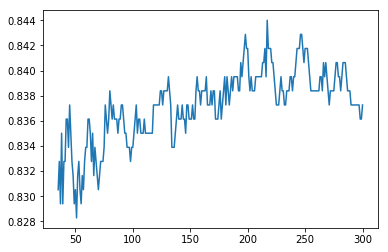

In [8]:
# Use random forest, no need for KFold since we have OOB score
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
from time import time
from sklearn.ensemble import RandomForestClassifier
print("Random Forest")
min_estimators = 35
max_estimators = 300
sc = np.zeros(max_estimators-min_estimators+1)
rf = RandomForestClassifier(warm_start=True, oob_score=True)
start_time = time()
for i in range(min_estimators, max_estimators + 1):
    rf.set_params(n_estimators=i)
    rf.fit(xN, yN)
    sc[i-min_estimators] = rf.oob_score_    
print("--- %s seconds ---" % (time() - start_time))
plt.plot(list(range(min_estimators, max_estimators + 1)),sc)

# The result stays around 0.84 after 200. That's a good CV score.

--- 1.3481192588806152 seconds ---


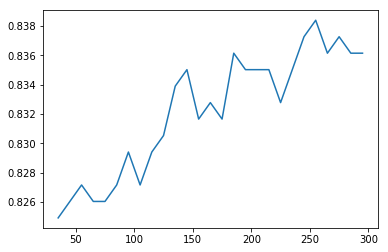

In [13]:
# Optimize random forest

min_estimators = 35
max_estimators = 300
step = 10
xlist = list(range(min_estimators, max_estimators + 1, step))
sc = np.zeros(len(xlist))
rf = RandomForestClassifier(warm_start=True, oob_score=True)
start_time = time()
for i, n_estimators in enumerate(xlist): # Try with step by 10 to be faster.
    rf.set_params(n_estimators=n_estimators)
    rf.fit(xN, yN)
    sc[i] = rf.oob_score_    
print("--- %s seconds ---" % (time() - start_time))
plt.plot(xlist,sc)

--- 10.153789043426514 seconds ---


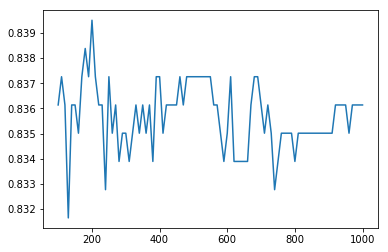

--- 2.674180269241333 seconds ---


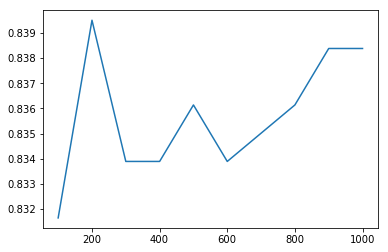

In [14]:
min_estimators = 100
max_estimators = 1000
step = 10
xlist = list(range(min_estimators, max_estimators + 1, step))
sc = np.zeros(len(xlist))
rf = RandomForestClassifier(warm_start=True, oob_score=True)
start_time = time()
for i, n_estimators in enumerate(xlist): # Try with step by 10 to be faster.
    rf.set_params(n_estimators=n_estimators)
    rf.fit(xN, yN)
    sc[i] = rf.oob_score_    
print("--- %s seconds ---" % (time() - start_time))
plt.plot(xlist,sc)
plt.show()

# Compare with step = 100
step = 100
xlist = list(range(min_estimators, max_estimators + 1, step))
sc = np.zeros(len(xlist))
rf = RandomForestClassifier(warm_start=True, oob_score=True)
start_time = time()
for i, n_estimators in enumerate(xlist): # Try with step by 100 to be faster.
    rf.set_params(n_estimators=n_estimators)
    rf.fit(xN, yN)
    sc[i] = rf.oob_score_    
print("--- %s seconds ---" % (time() - start_time))
plt.plot(xlist,sc)
plt.show()

1 0.837528726418 0.00165764121846 --- 3.883882522583008 seconds ---


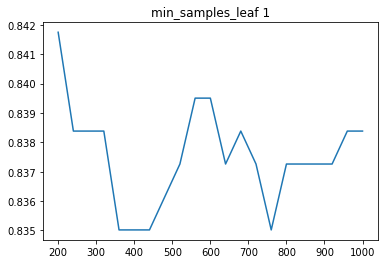

2 0.849714071936 0.00129154465006 --- 3.5814130306243896 seconds ---


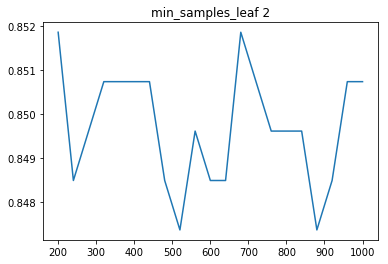

3 0.849233071455 0.00139979700216 --- 3.5500001907348633 seconds ---


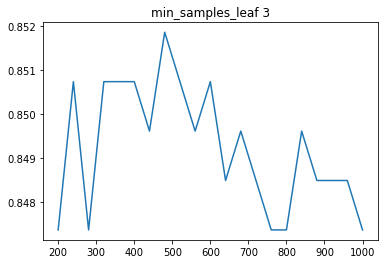

4 0.84581262359 0.00228377538552 --- 3.475919008255005 seconds ---


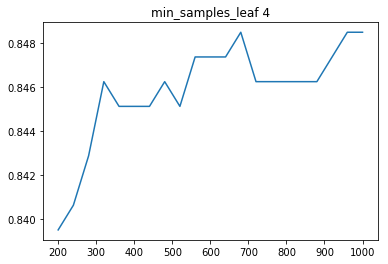

5 0.84885895997 0.00116602128316 --- 3.438368797302246 seconds ---


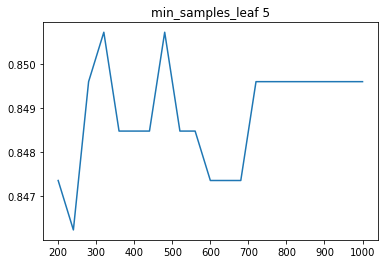

6 0.850462294907 0.00169344017078 --- 3.4985153675079346 seconds ---


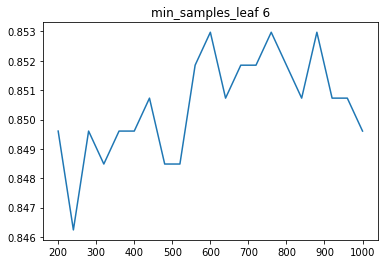

7 0.846240179574 0.00119982600185 --- 3.4723904132843018 seconds ---


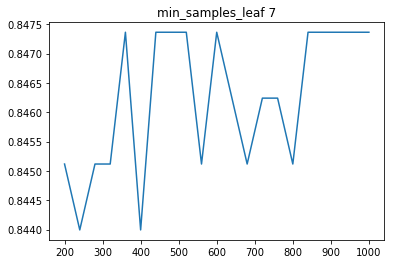

8 0.846347068569 0.00129154465006 --- 3.3865065574645996 seconds ---


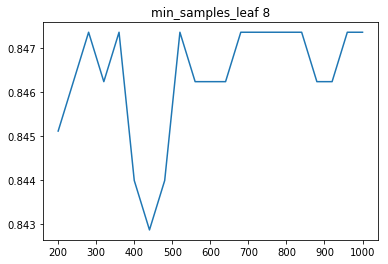

9 0.8430335097 0.000796305083948 --- 3.5091934204101562 seconds ---


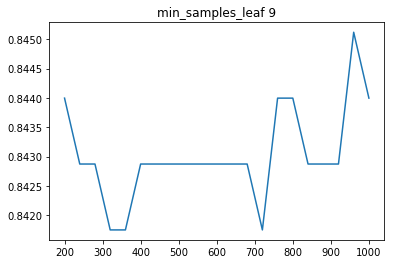

10 0.84126984127 0.00164553517378 --- 3.3956050872802734 seconds ---


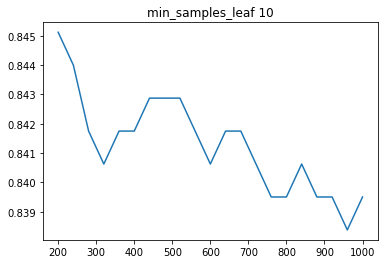

11 0.838330393886 0.00152855001294 --- 3.51141619682312 seconds ---


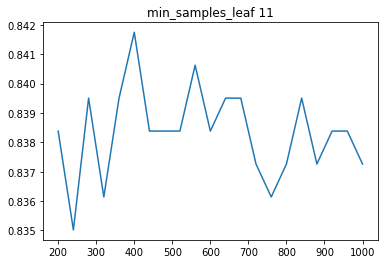

12 0.839345839346 0.00121402562039 --- 3.296229600906372 seconds ---


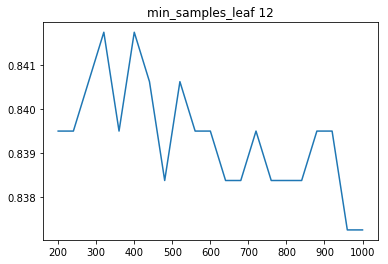

13 0.83720805943 0.00136257268815 --- 3.2802133560180664 seconds ---


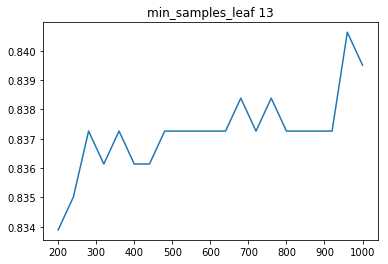

14 0.839933728823 0.00131781604467 --- 3.377955436706543 seconds ---


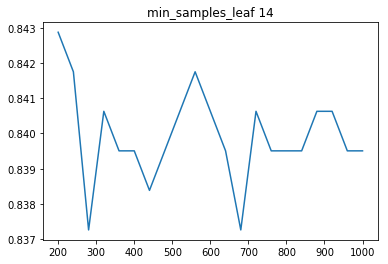

15 0.842124953236 0.00126472765391 --- 3.3630003929138184 seconds ---


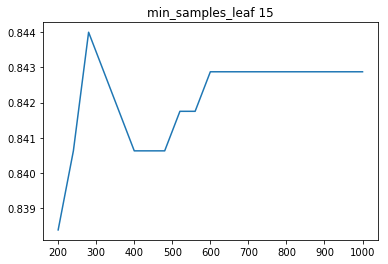

16 0.842338731228 0.00112867896328 --- 3.291738748550415 seconds ---


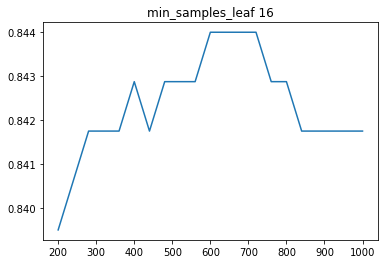

17 0.836032280477 0.00138131024353 --- 3.3028457164764404 seconds ---


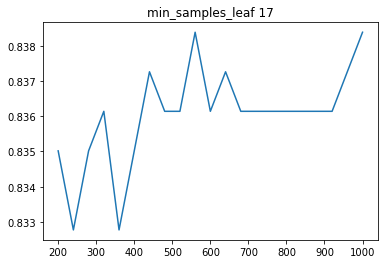

18 0.838383838384 0.00150974794419 --- 3.3288769721984863 seconds ---


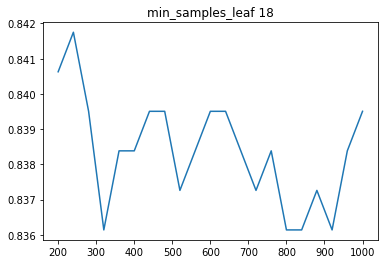

19 0.835444391 0.00140590523627 --- 3.246302843093872 seconds ---


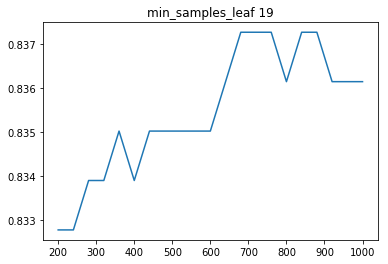

20 0.83619261397 0.00178219571381 --- 3.2943789958953857 seconds ---


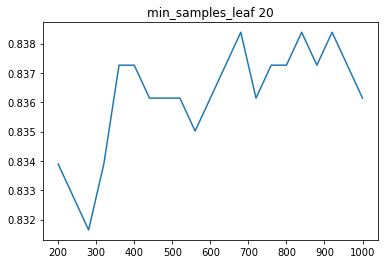

21 0.839666506333 0.00148109737166 --- 3.2212424278259277 seconds ---


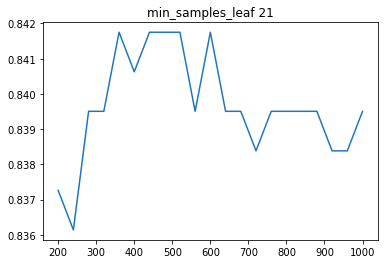

22 0.837154614932 0.000767072849896 --- 3.3508801460266113 seconds ---


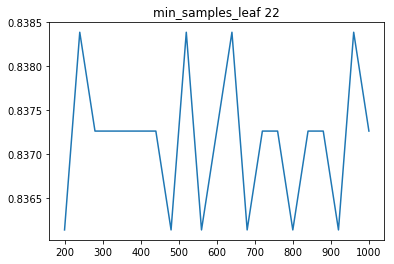

23 0.832451499118 0.00259522431557 --- 3.2633819580078125 seconds ---


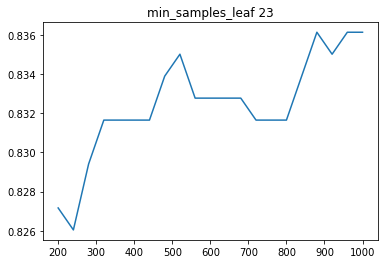

24 0.834963390519 0.00140590523627 --- 3.315325975418091 seconds ---


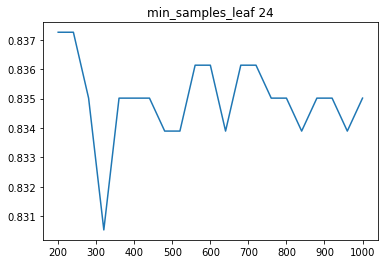

25 0.835230613008 0.00218011630104 --- 3.2557084560394287 seconds ---


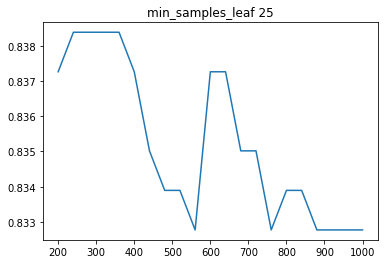

26 0.833466944578 0.00140590523627 --- 3.393049716949463 seconds ---


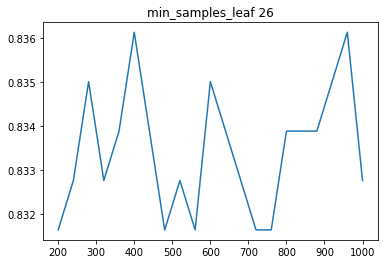

27 0.830206830207 0.00180449393577 --- 3.5489368438720703 seconds ---


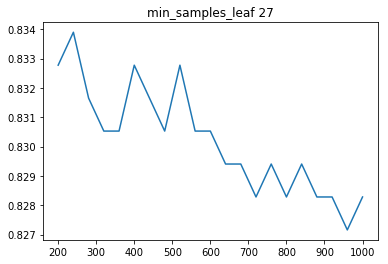

28 0.829084495751 0.00186979377741 --- 3.5509400367736816 seconds ---


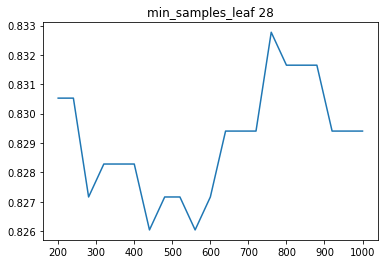

29 0.831275720165 0.00177738112857 --- 3.1385035514831543 seconds ---


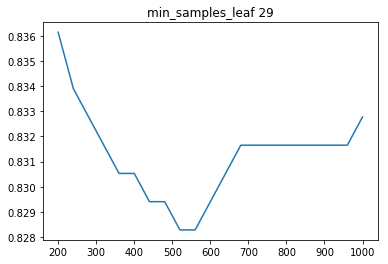

30 0.829939607717 0.00185291388203 --- 3.1468639373779297 seconds ---


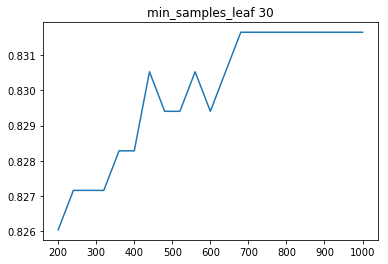

31 0.827053604831 0.00142407274806 --- 3.213169574737549 seconds ---


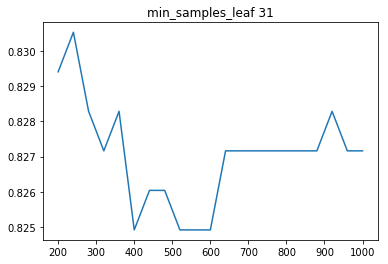

32 0.828015605793 0.00133718090997 --- 3.175475597381592 seconds ---


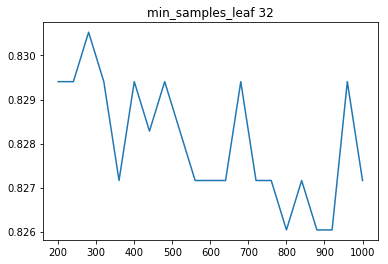

33 0.823152156485 0.00181868414592 --- 3.191556215286255 seconds ---


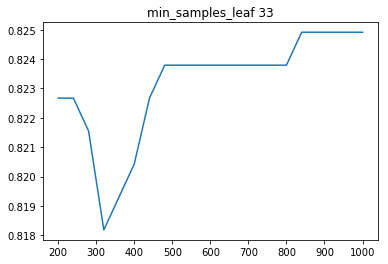

34 0.828763828764 0.0026280350282 --- 3.1861865520477295 seconds ---


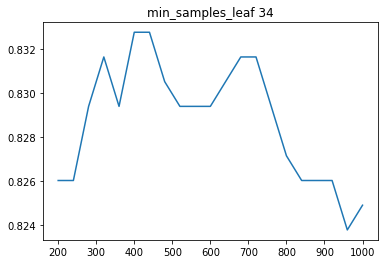

35 0.825129602907 0.00220745833232 --- 3.0979132652282715 seconds ---


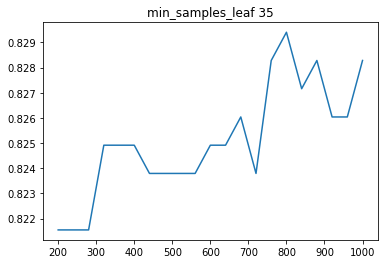

36 0.828763828764 0.00197672406701 --- 3.1384623050689697 seconds ---


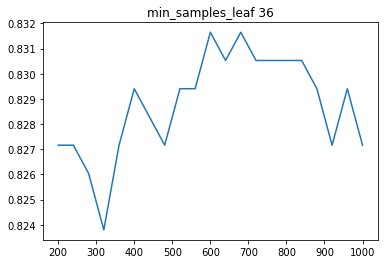

37 0.827053604831 0.00224212249088 --- 3.1385445594787598 seconds ---


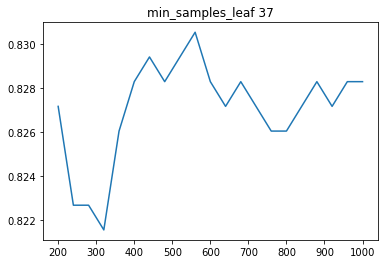

38 0.822671156004 0.00114874593876 --- 3.1488986015319824 seconds ---


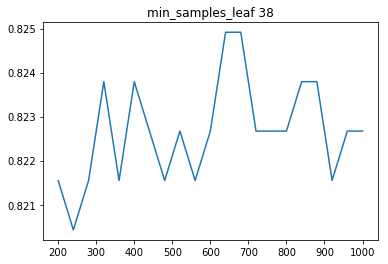

39 0.827160493827 0.00162457208632 --- 3.162482261657715 seconds ---


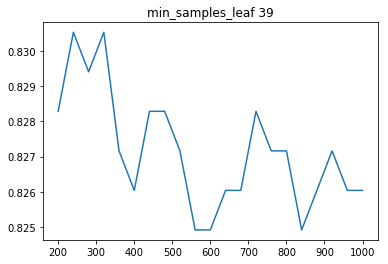

40 0.827107049329 0.00341961269265 --- 3.098466396331787 seconds ---


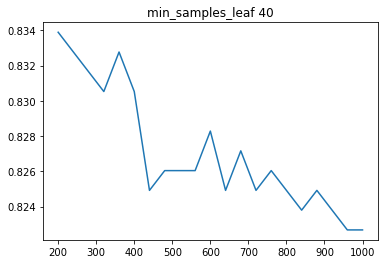

41 0.823846934958 0.00197383200391 --- 3.1464099884033203 seconds ---


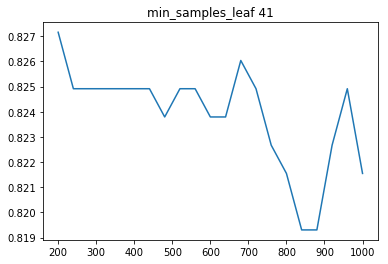

42 0.822136711026 0.00194761019275 --- 3.0877788066864014 seconds ---


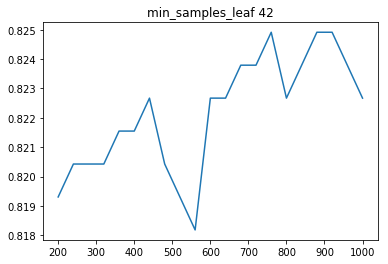

43 0.817914595692 0.00158361737908 --- 3.072699785232544 seconds ---


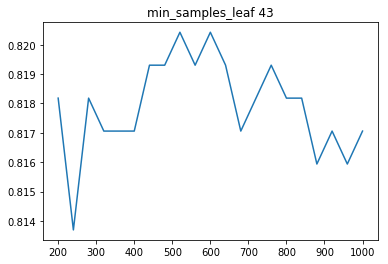

44 0.819357597135 0.00164205991083 --- 3.1358368396759033 seconds ---


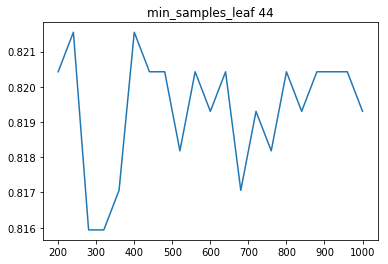

45 0.817593928705 0.00218011630104 --- 3.0487618446350098 seconds ---


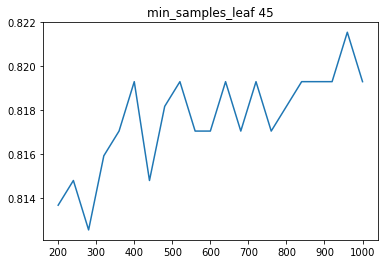

46 0.820854043076 0.00387979079961 --- 2.992088794708252 seconds ---


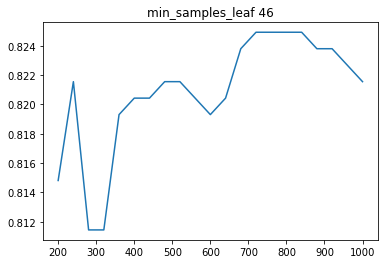

47 0.817700817701 0.00238891525184 --- 3.1865057945251465 seconds ---


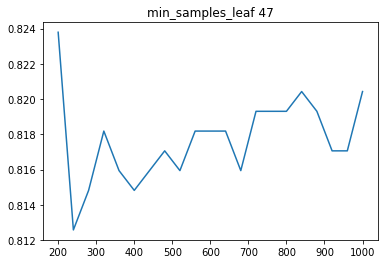

48 0.812837368393 0.00291652261229 --- 3.0767197608947754 seconds ---


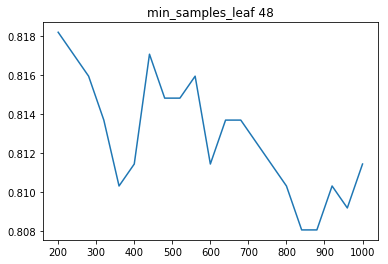

49 0.814333814334 0.0025819832888 --- 3.103358268737793 seconds ---


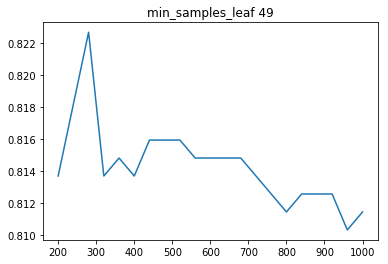

50 0.817059483726 0.00142807858649 --- 3.1172852516174316 seconds ---


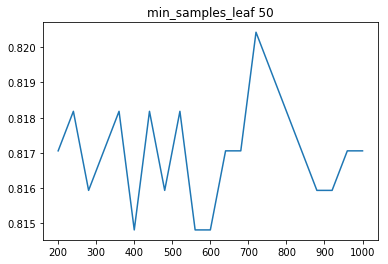

51 0.809844476511 0.00397290738925 --- 3.0471251010894775 seconds ---


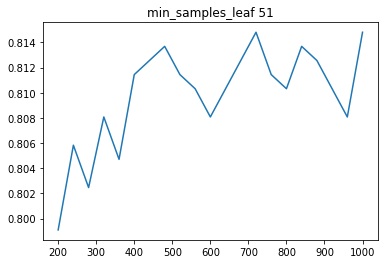

52 0.800224466891 0.00380995925832 --- 3.017073392868042 seconds ---


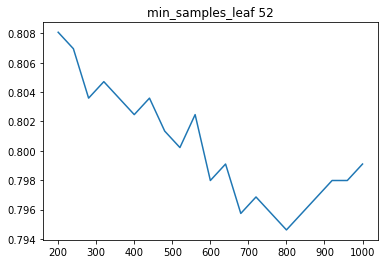

53 0.802469135802 0.00219057255432 --- 3.0937304496765137 seconds ---


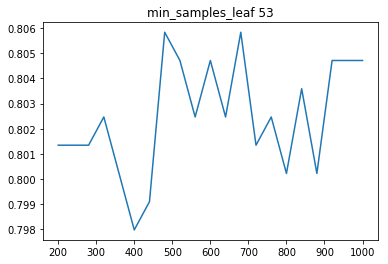

54 0.803965581743 0.00395417055488 --- 3.0687623023986816 seconds ---


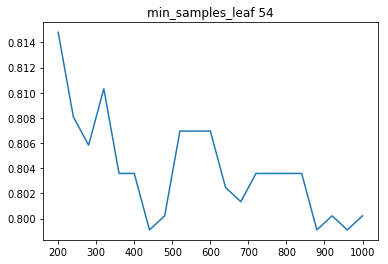

55 0.799903799904 0.00266366004904 --- 3.0932273864746094 seconds ---


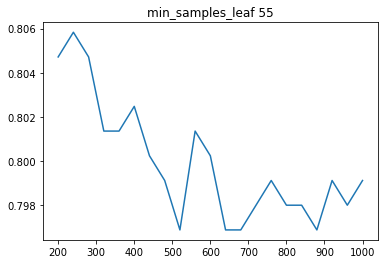

56 0.789001122334 0.00254521530646 --- 3.045659065246582 seconds ---


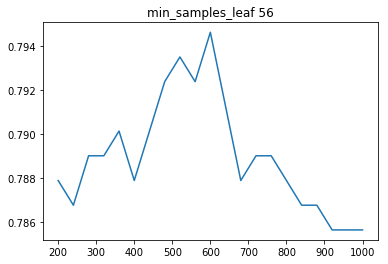

57 0.789802789803 0.0015926101679 --- 3.0147788524627686 seconds ---


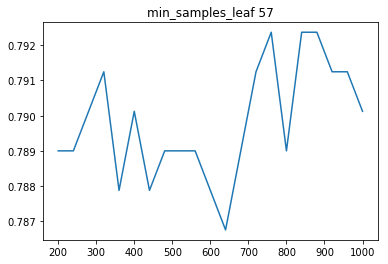

58 0.789268344824 0.00109005815052 --- 3.0198166370391846 seconds ---


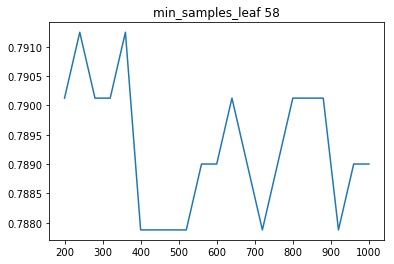

59 0.791566458233 0.00196367624081 --- 2.986056327819824 seconds ---


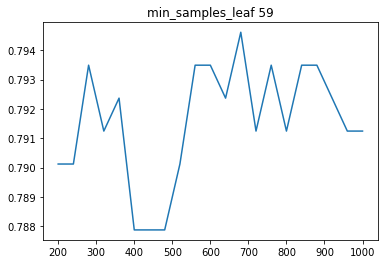

60 0.788947677837 0.00127148492901 --- 2.994537353515625 seconds ---


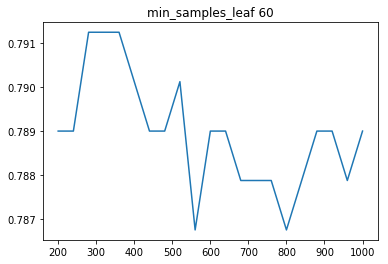

61 0.788520121853 0.00171689149743 --- 3.0236117839813232 seconds ---


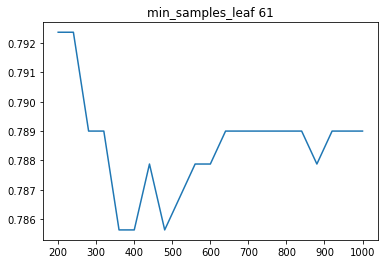

62 0.790283790284 0.00111082302874 --- 3.039330244064331 seconds ---


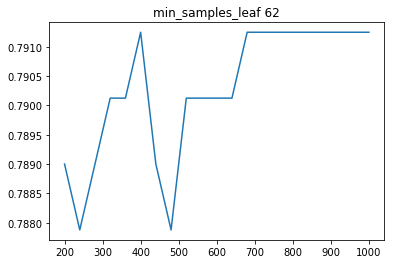

63 0.787878787879 0.0013854397303 --- 3.036257266998291 seconds ---


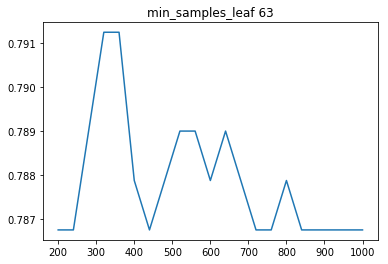

64 0.789909678799 0.00136884703916 --- 3.0705087184906006 seconds ---


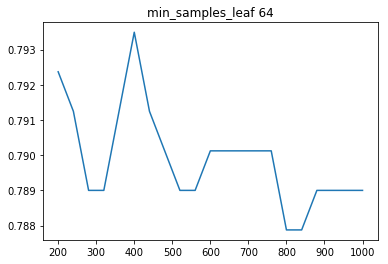

65 0.787771898883 0.002422162192 --- 2.990525722503662 seconds ---


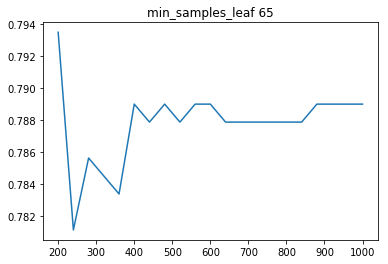

66 0.787611565389 0.000590313773566 --- 3.059628486633301 seconds ---


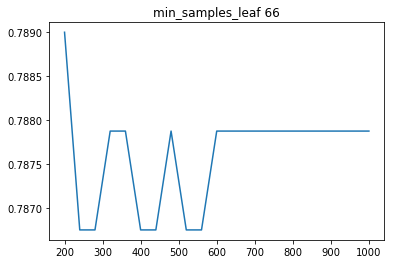

67 0.786008230453 0.00121637610782 --- 3.001690149307251 seconds ---


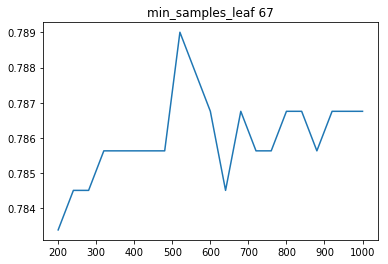

68 0.788306343862 0.00304867953545 --- 3.0081868171691895 seconds ---


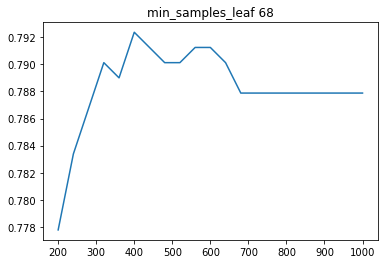

69 0.788146010368 0.00119505530303 --- 3.034071445465088 seconds ---


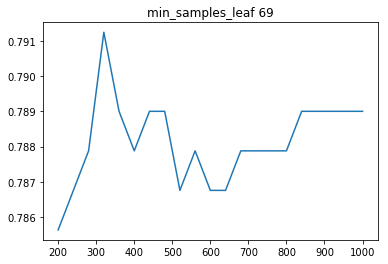

70 0.787718454385 0.00135416166526 --- 3.0648701190948486 seconds ---


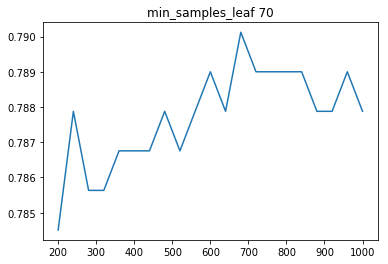

71 0.785634118967 0.00422786178004 --- 3.0092246532440186 seconds ---


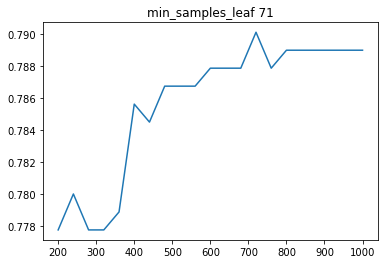

72 0.788947677837 0.00178219571381 --- 3.02573823928833 seconds ---


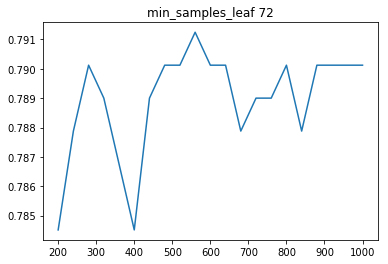

73 0.786863342419 0.00265829300742 --- 3.082315444946289 seconds ---


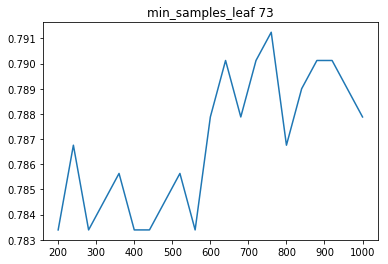

74 0.789749345305 0.000721005695218 --- 3.1094248294830322 seconds ---


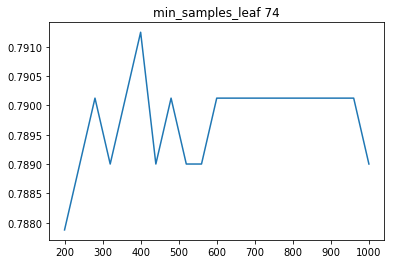

75 0.786649564427 0.000910127003684 --- 3.1284191608428955 seconds ---


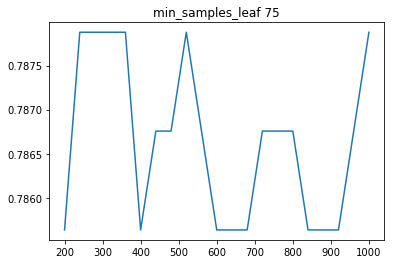

76 0.786382341938 0.00245728479131 --- 3.1584980487823486 seconds ---


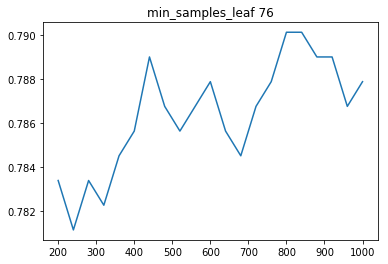

KeyboardInterrupt: 

In [16]:
# Optimize random forest
min_estimators = 200
max_estimators = 1000
step = 40 # I want around 20 points to have a good idea of the mean result and whether it increases with the number of trees.
# (1000-200)/40 = 20
xlist = list(range(min_estimators, max_estimators + 1, step))
sc = np.zeros(len(xlist))
start_time = time()
for min_samples_leaf in range(1,100):
    rf = RandomForestClassifier(warm_start=True, oob_score=True, min_samples_leaf=min_samples_leaf)
    start_time = time()
    for i, n_estimators in enumerate(xlist):
        rf.set_params(n_estimators=n_estimators)
        rf.fit(xN, yN)
        sc[i] = rf.oob_score_    
    print(min_samples_leaf, sc.mean(), sc.std(), "--- %s seconds ---" % (time() - start_time))
    plt.plot(xlist,sc)
    plt.title('min_samples_leaf %s' % min_samples_leaf )
    plt.show()
    
# Got 0.850462294907 for min_samples_leaf = 6, number of trees is best > 600 where it's more 0.852.
# For bigger min_samples_leaf it gets less good.

In [19]:
repeat = 10
sc = np.zeros(repeat)
start_time = time()
for min_samples_leaf in range(1,8):
    rf = RandomForestClassifier(warm_start=False, n_estimators=1000, oob_score=True, min_samples_leaf=min_samples_leaf)
    start_time = time()
    for i in range(repeat):
        rf.fit(xN, yN)
        sc[i] = rf.oob_score_    
    print(min_samples_leaf, sc.mean(), sc.std(), "--- %s seconds ---" % (time() - start_time))

1 0.837261503928 0.00200769290909 --- 18.539087772369385 seconds ---
2 0.85140291807 0.002417582405 --- 18.123882055282593 seconds ---
3 0.848709315376 0.00223341736724 --- 18.149359703063965 seconds ---
4 0.848148148148 0.00213243546577 --- 16.586563110351562 seconds ---
5 0.849943883277 0.00150994658216 --- 16.234215259552002 seconds ---
6 0.850056116723 0.00114456105805 --- 16.10945200920105 seconds ---
7 0.848372615039 0.00190796857464 --- 16.05974054336548 seconds ---


In [20]:
repeat = 10
sc = np.zeros(repeat)
start_time = time()
for min_samples_leaf in [2,6]:
    rf = RandomForestClassifier(warm_start=False, n_estimators=3000, oob_score=True, min_samples_leaf=min_samples_leaf)
    start_time = time()
    for i in range(repeat):
        rf.fit(xN, yN)
        sc[i] = rf.oob_score_    
    print(min_samples_leaf, sc.mean(), sc.std(), "--- %s seconds ---" % (time() - start_time))
    
# If we mutiply by number of examples: 757.6 +- 0.9   vs    757.9 +- 0.9
# So we cannot know which one is best.

2 0.850280583614 0.00102863651963 --- 56.58510231971741 seconds ---
6 0.850617283951 0.00105880820786 --- 48.84276795387268 seconds ---


In [23]:
print(sc) # This is the score for min_samples_leaf= 6
# We can see that there is 2 main results: 0.85185185 and 0.84960718 + one occurence of 0.85072952.
# 0.85185185*891 = 759
# 0.85072952*891 = 758
# 0.84960718*891 = 757

# Thus, it doesn't change much.

[ 0.85185185  0.85185185  0.84960718  0.85072952  0.85185185  0.84960718
  0.85185185  0.84960718  0.84960718  0.84960718]


In [25]:
repeat = 10
sc = np.zeros(repeat,dtype=np.int)
start_time = time()
for min_samples_leaf in [2,6]:
    rf = RandomForestClassifier(warm_start=False, n_estimators=5000, oob_score=True, min_samples_leaf=min_samples_leaf)
    start_time = time()
    for i in range(repeat):
        rf.fit(xN, yN)
        sc[i] = int(rf.oob_score_*891) # Thus, it's the number of good answer
    print(min_samples_leaf, sc.mean(), sc.std(), "--- %s seconds ---" % (time() - start_time))
    print(sc)

2 758.0 0.774596669241 --- 86.21443891525269 seconds ---
[760 758 758 758 758 757 757 758 758 758]
6 758.2 0.871779788708 --- 80.26423525810242 seconds ---
[758 759 758 758 757 758 760 758 757 759]


In [26]:
repeat = 10
sc = np.zeros(repeat,dtype=np.int)
start_time = time()
for min_samples_leaf in [2,6]:
    rf = RandomForestClassifier(warm_start=False, n_estimators=10000, oob_score=True, min_samples_leaf=min_samples_leaf)
    start_time = time()
    for i in range(repeat):
        rf.fit(xN, yN)
        sc[i] = int(rf.oob_score_*891) # Thus, it's the number of good answer
    print(min_samples_leaf, sc.mean(), sc.std(), "--- %s seconds ---" % (time() - start_time))
    print(sc)

2 757.7 0.781024967591 --- 171.11921763420105 seconds ---
[758 758 757 758 757 757 759 759 757 757]
6 758.2 0.6 --- 158.13562297821045 seconds ---
[758 758 758 759 757 759 758 758 759 758]


In [33]:
# The uncertainty didn't improve when I went from 5000 to 10000.
# It might be good to look again the in between min_samples_leaf with more precision.

repeat = 10
sc = np.zeros(repeat,dtype=np.int)
start_time = time()
for min_samples_leaf in [2,3,4,5,6]:
    rf = RandomForestClassifier(warm_start=False, n_estimators=5000, oob_score=True, min_samples_leaf=min_samples_leaf)
    start_time = time()
    for i in range(repeat):
        rf.fit(xN, yN)
        sc[i] = int(rf.oob_score_*891) # Thus, it's the number of good answer
    print(min_samples_leaf, sc.mean(), sc.std(), "--- %s seconds ---" % (time() - start_time))
    print(sc)
    
# It seems that the best in accuracy and uncertainty of accuracy is min_samples_leaf=6 though the uncertainty is too high to be
# sure it's the best. It is also faster than 2 or 3.

2 757.9 0.943398113206 --- 86.74471497535706 seconds ---
[757 757 757 759 760 757 758 758 758 758]
3 757.2 0.6 --- 84.21805357933044 seconds ---
[757 758 757 757 758 757 757 756 757 758]
4 757.2 1.72046505341 --- 81.98138093948364 seconds ---
[755 758 755 757 755 757 759 757 760 759]
5 757.6 0.8 --- 81.79102921485901 seconds ---
[757 759 757 758 759 757 757 757 757 758]
6 758.2 0.748331477355 --- 81.82483124732971 seconds ---
[758 758 758 759 757 758 757 759 759 759]


In [28]:
# Test dropping some features:

# I assume that with n_estimators = 3000, the result should not change much if we repeat it as I looked previously and it
# changed only by 2 answers. So if the result drop by more than 2, it's probably sign than the feature is important, and if it
# increases by more than 2, the feature is bad.

# I use min_samples_leaf=6 because the result is very similar from 2 to 6, but the time needed decreases.

# Without dropping
rf = RandomForestClassifier(oob_score=True, min_samples_leaf=6, n_estimators = 3000)
start_time = time()
rf.fit(xN, yN)
sc = int(rf.oob_score_*891) # Thus, it's the number of good answer    
print("No drop", sc, "--- %s seconds ---" % (time() - start_time))


for dropfeature in list(xN):
    x0 = xN.drop(dropfeature,axis=1)
    rf = RandomForestClassifier(oob_score=True, min_samples_leaf=6, n_estimators = 3000)
    start_time = time()
    rf.fit(x0, yN)
    sc = int(rf.oob_score_*891) # Thus, it's the number of good answer
    print(dropfeature, sc, "--- %s seconds ---" % (time() - start_time))
    
# It seems than dropping any of those feature doesn't do much differences. Everything is between 755 and 760.

No drop 757 --- 4.872998476028442 seconds ---
Age 757 --- 4.703076362609863 seconds ---
Fare 759 --- 4.626014232635498 seconds ---
Parch 760 --- 4.846439361572266 seconds ---
Sex 757 --- 4.828570127487183 seconds ---
SibSp 759 --- 4.703651666641235 seconds ---
Ticket_count 757 --- 4.757646560668945 seconds ---
FarePerPerson 756 --- 4.925769567489624 seconds ---
Family 758 --- 4.706383466720581 seconds ---
SameTicketSurvival 755 --- 4.697016716003418 seconds ---
LastNameSurvival 758 --- 4.656468868255615 seconds ---
CabinNumber 756 --- 4.768015384674072 seconds ---
Embarked_C 759 --- 4.707101345062256 seconds ---
Embarked_Q 758 --- 4.745183944702148 seconds ---
Embarked_S 758 --- 4.6810829639434814 seconds ---
Pclass_1st 758 --- 4.787332057952881 seconds ---
Pclass_2nd 760 --- 4.836419343948364 seconds ---
Pclass_3rd 758 --- 4.854326486587524 seconds ---
title_Dr. 760 --- 4.762748956680298 seconds ---
title_Master. 755 --- 4.876643896102905 seconds ---
title_Miss. 759 --- 4.837547779083

In [34]:
# Drop the ones that gave me 759 or 760 before
x0 = (xN.drop('Fare',axis=1).drop('Parch',axis=1).drop('SibSp',axis=1).drop('Embarked_C',axis=1).drop('Pclass_2nd',axis=1)
      .drop('title_Dr.',axis=1).drop('title_Miss.',axis=1).drop('title_Other',axis=1).drop('3M',axis=1)
     )

# Without dropping more
rf = RandomForestClassifier(oob_score=True, min_samples_leaf=6, n_estimators = 3000)
start_time = time()
rf.fit(x0, yN)
sc = int(rf.oob_score_*891) # Thus, it's the number of good answer    
print("No drop", sc, "--- %s seconds ---" % (time() - start_time))


for dropfeature in list(x0):
    x1 = x0.drop(dropfeature,axis=1)
    rf = RandomForestClassifier(oob_score=True, min_samples_leaf=6, n_estimators = 3000)
    start_time = time()
    rf.fit(x1, yN)
    sc = int(rf.oob_score_*891) # Thus, it's the number of good answer
    print(dropfeature, sc, "--- %s seconds ---" % (time() - start_time))
    
# Now that we have a bit less features, each of them is more important, so we see bigger differences.

No drop 758 --- 4.595794677734375 seconds ---
Age 762 --- 4.481139659881592 seconds ---
Sex 760 --- 4.697101831436157 seconds ---
Ticket_count 759 --- 4.478790044784546 seconds ---
FarePerPerson 752 --- 4.389690637588501 seconds ---
Family 758 --- 4.522667646408081 seconds ---
SameTicketSurvival 757 --- 4.536150693893433 seconds ---
LastNameSurvival 755 --- 4.6263954639434814 seconds ---
CabinNumber 761 --- 4.638330459594727 seconds ---
Embarked_Q 758 --- 4.617906332015991 seconds ---
Embarked_S 757 --- 4.530613422393799 seconds ---
Pclass_1st 759 --- 4.608357906341553 seconds ---
Pclass_3rd 758 --- 4.625930547714233 seconds ---
title_Master. 758 --- 4.601394176483154 seconds ---
title_Mr. 758 --- 4.552156686782837 seconds ---
title_Mrs. 759 --- 4.615965843200684 seconds ---
title_Rev. 759 --- 4.664399862289429 seconds ---
CabinLetter_A 761 --- 4.572654485702515 seconds ---
CabinLetter_B 760 --- 4.587259292602539 seconds ---
CabinLetter_C 759 --- 4.566639423370361 seconds ---
CabinLett

In [36]:
# Let's remove everything that gave me >=760
x1 = (x0.drop('Age',axis=1).drop('Sex',axis=1).drop('CabinNumber',axis=1).drop('CabinLetter_A',axis=1)
      .drop('CabinLetter_B',axis=1).drop('CabinLetter_D',axis=1).drop('CabinLetter_E',axis=1).drop('CabinLetter_G',axis=1)
     )

# Without dropping more
rf = RandomForestClassifier(oob_score=True, min_samples_leaf=6, n_estimators = 3000)
start_time = time()
rf.fit(x1, yN)
sc = int(rf.oob_score_*891) # Thus, it's the number of good answer    
print("No drop", sc, "--- %s seconds ---" % (time() - start_time))


for dropfeature in list(x1):
    x2 = x1.drop(dropfeature,axis=1)
    rf = RandomForestClassifier(oob_score=True, min_samples_leaf=6, n_estimators = 3000)
    start_time = time()
    rf.fit(x2, yN)
    sc = int(rf.oob_score_*891) # Thus, it's the number of good answer
    print(dropfeature, sc, "--- %s seconds ---" % (time() - start_time))

# Thus, I clearly dropped too many features and now the result is less good.

No drop 752 --- 4.51370644569397 seconds ---
Ticket_count 756 --- 4.484572172164917 seconds ---
FarePerPerson 752 --- 4.468946933746338 seconds ---
Family 753 --- 4.454954624176025 seconds ---
SameTicketSurvival 752 --- 4.327003002166748 seconds ---
LastNameSurvival 751 --- 4.26739501953125 seconds ---
Embarked_Q 755 --- 4.448668003082275 seconds ---
Embarked_S 755 --- 4.435279369354248 seconds ---
Pclass_1st 755 --- 4.496065855026245 seconds ---
Pclass_3rd 753 --- 4.581219434738159 seconds ---
title_Master. 751 --- 4.415860891342163 seconds ---
title_Mr. 736 --- 4.3265392780303955 seconds ---
title_Mrs. 753 --- 4.651522159576416 seconds ---
title_Rev. 753 --- 4.438451766967773 seconds ---
CabinLetter_C 754 --- 4.372154712677002 seconds ---
CabinLetter_F 752 --- 4.351077079772949 seconds ---
CabinLetter_T 753 --- 4.2785468101501465 seconds ---
OtherFemale 754 --- 4.303715705871582 seconds ---
OtherMale 753 --- 4.301663875579834 seconds ---
1F 752 --- 4.371767282485962 seconds ---
2F 75

In [44]:
# Drop only age, should get 762

# Let's remove everything that gave me >=760
x0 = (xN.drop('Fare',axis=1).drop('Parch',axis=1).drop('SibSp',axis=1).drop('Embarked_C',axis=1).drop('Pclass_2nd',axis=1)
      .drop('title_Dr.',axis=1).drop('title_Miss.',axis=1).drop('title_Other',axis=1).drop('3M',axis=1)
     )
x1 = x0.drop('Age',axis=1)

# Without dropping more
rf = RandomForestClassifier(oob_score=True, min_samples_leaf=6, n_estimators = 3000)
start_time = time()
rf.fit(x1, yN)
sc = int(rf.oob_score_*891) # Thus, it's the number of good answer    
print("No drop", sc, "--- %s seconds ---" % (time() - start_time))


for dropfeature in list(x1):
    x2 = x1.drop(dropfeature,axis=1)
    rf = RandomForestClassifier(oob_score=True, min_samples_leaf=6, n_estimators = 3000)
    start_time = time()
    rf.fit(x2, yN)
    sc = int(rf.oob_score_*891) # Thus, it's the number of good answer
    print(dropfeature, sc, "--- %s seconds ---" % (time() - start_time))

# The result clearly improved. It's not clear it could still be improved since the best results are 762 which is not
# significantly better.

No drop 761 --- 4.5252685546875 seconds ---
Sex 757 --- 4.352926254272461 seconds ---
Ticket_count 761 --- 4.484955072402954 seconds ---
FarePerPerson 746 --- 4.226752758026123 seconds ---
Family 758 --- 4.389084100723267 seconds ---
SameTicketSurvival 759 --- 4.457415819168091 seconds ---
LastNameSurvival 754 --- 4.224545240402222 seconds ---
CabinNumber 755 --- 4.225537538528442 seconds ---
Embarked_Q 761 --- 4.312092065811157 seconds ---
Embarked_S 760 --- 4.374238967895508 seconds ---
Pclass_1st 761 --- 4.3169238567352295 seconds ---
Pclass_3rd 758 --- 4.418116569519043 seconds ---
title_Master. 760 --- 4.353986978530884 seconds ---
title_Mr. 751 --- 4.314377784729004 seconds ---
title_Mrs. 759 --- 4.334061145782471 seconds ---
title_Rev. 760 --- 4.431278944015503 seconds ---
CabinLetter_A 760 --- 4.337075471878052 seconds ---
CabinLetter_B 762 --- 4.56453800201416 seconds ---
CabinLetter_C 761 --- 4.36669135093689 seconds ---
CabinLetter_D 762 --- 4.416860580444336 seconds ---
Cab

In [43]:
# Try to find better ways to drop

rf = RandomForestClassifier(oob_score=True, min_samples_leaf=6, n_estimators = 3000)
start_time = time()
rf.fit(xN, yN)
bestsc = int(rf.oob_score_*891) # Thus, it's the number of good answer    
print("No drop", bestsc, "--- %s seconds ---" % (time() - start_time))

def dropfeature(x0):
    for dropfeature in list(x0):
        global bestsc
        x1 = x0.drop(dropfeature,axis=1)
        rf = RandomForestClassifier(oob_score=True, min_samples_leaf=6, n_estimators = 3000)
        rf.fit(x1, yN)
        sc = int(rf.oob_score_*891) # Thus, it's the number of good answer
        if sc > bestsc:
            bestsc = sc
            bestdropfeature = dropfeature    
    return bestdropfeature
        
x0 = xN
oldbestsc = 0
while bestsc > oldbestsc:
    start_time = time()
    oldbestsc = bestsc
    bestdropfeature = dropfeature(x0)
    x0 = x0.drop(bestdropfeature,axis=1)
    print(bestdropfeature, bestsc, "--- %s seconds ---" % (time() - start_time))
    
# It seems that it doesn't improve more than 760 with this method.

No drop 758 --- 5.084593772888184 seconds ---
SibSp 760 --- 192.1125841140747 seconds ---


UnboundLocalError: local variable 'bestdropfeature' referenced before assignment

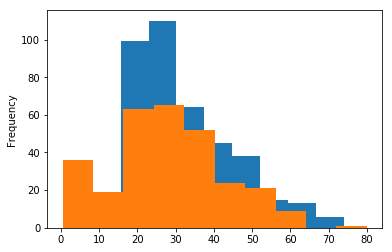

In [57]:
# Find a better way to use Age
# The problem with it might be that we replace NaN by mean.
# I could also replace it by mean depending of title since some title are younger than other.
# Or replacing using a random forest regressor.

# Plot survivance vs age

agedata = combine_df[['Age','Survived']].dropna()
agedata0 = agedata[agedata['Survived']==0]
agedata1 = agedata[agedata['Survived']==1]
agedata0['Age'].plot(kind='hist')
agedata1['Age'].plot(kind='hist', style=['r'])

In [ ]:
# Find a better way to use Age
# The problem with it might be that we replace NaN by mean.

# Remove NaN by replacing by mean
value = {key : combine_df[key].mean() for key in list(combine_df)}
combine_dfN = combine_df.fillna(value=value)

# Separate in train and test
train_dfN = combine_dfN[pd.notnull(combine_df['Survived'])]
test_dfN = combine_dfN[False == pd.notnull(combine_df['Survived'])]
xN = train_dfN.drop('Survived',axis=1)
yN = train_dfN['Survived']

xN.describe()

In [ ]:
# Use best result from random forest to test on Kaggle dataset.

In [ ]:
# Optimize random forest
def objective(space):
    param={'min_sample_leaf' : space['min_sample_leaf'],
     'max_depth' : int(space['max_depth']),
     'min_child_weight' : space['min_child_weight'],
        'gamma' : space['gamma'],
     'subsample' : space['subsample'],
     'colsample_bytree' :space['colsample_bytree'],
     'nthread' : -1,
     'colsample_bylevel' :space['colsample_bylevel'],
        'reg_alpha' :space['reg_alpha'],
     'reg_lambda' :space['reg_lambda']  
          }
    error = 0
    for i in repeat:
        seed = randint(0, 100000)
        cvresult = xgb.cv(param, dmatrix, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=10, shuffle = True, seed=seed)
        error += cvresult['test-auc-mean'].tail(1).values[0]
    error /= nrepeat

    return{'loss':1-error, 'status': STATUS_OK }


space ={
        'max_depth': hp.quniform ('max_depth', 1, 14, 1),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.1, 1.),
        'learning_rate' : hp.uniform ('learning_rate', 0.01, 0.5),
       'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1.),
        'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.5, 1.),
        'gamma': hp.uniform ('gamma', 0., 1.),
    'reg_alpha': hp.uniform ('reg_alpha', 0., 1.),
    'reg_lambda' : hp.uniform ('reg_lambda', 0., 1.)
    }

trials = Trials()
start_time = time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print("--- %s seconds ---" % (time() - start_time))

best['max_depth'] = int(best['max_depth'])
print (best)

import numpy as np
start_time = time()
n_estimators = []
Error = []
for i in range(100):
    seed = randint(0, 100000)
    cvresult = xgb.cv(best, dmatrix, num_boost_round=1000, nfold=5,
                metrics=evalmetrics, early_stopping_rounds=50, shuffle = True, seed=seed)
    n_estimators.append(cvresult.shape[0])
    Error.append(cvresult['test-auc-mean'].tail(1).values[0])
print("--- %s seconds ---" % (time() - start_time))
n_estimators_mean = np.mean(n_estimators)
n_estimators_std = np.std(n_estimators)
Error_mean = np.mean(Error)
Error_std = np.std(Error)
print(n_estimators_mean, n_estimators_std, Error_mean, Error_std)

In [ ]:
# Optimize random forest
# https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

# !! Maybe use hyperopt

min_estimators = 100
max_estimators = 200
sc = np.zeros(max_estimators-min_estimators+1)
for 
    rf = RandomForestClassifier(warm_start=True, oob_score=True)
    start_time = time()
    for i in range(min_estimators, max_estimators + 1):
        rf.set_params(n_estimators=i)
        rf.fit(xN, yN)
        sc[i-min_estimators] = rf.oob_score_    
    print("--- %s seconds ---" % (time() - start_time))
    plt.plot(list(range(min_estimators, max_estimators + 1)),sc)

In [ ]:
# Optimize polynomial SVM with degree 3

In [ ]:
# Important: Redo the cell where I try many algorithms, but normalize input first. Some like age and fare aren't normalize
# so they get bad results with SVM.